In [50]:
# Paso 1: Importación de bibliotecas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import kendalltau, pointbiserialr

# Integración de Weka (segura)
try:
    import weka.core.jvm as jvm
    from weka.core.converters import Loader
    from weka.classifiers import Classifier, Evaluation
    from weka.core.classes import Random
    weka_available = True
except:
    weka_available = False

# Integración de R (segura)
"""
try:
    import rpy2.robjects as ro
    from rpy2.robjects import pandas2ri
    pandas2ri.activate()
    r_available = True
except:
    r_available = False
"""





'\ntry:\n    import rpy2.robjects as ro\n    from rpy2.robjects import pandas2ri\n    pandas2ri.activate()\n    r_available = True\nexcept:\n    r_available = False\n'

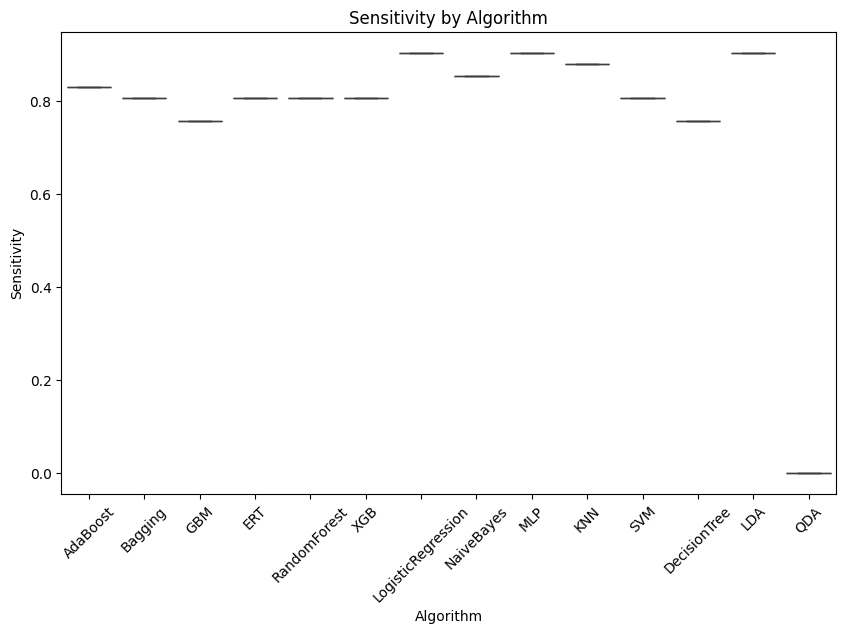

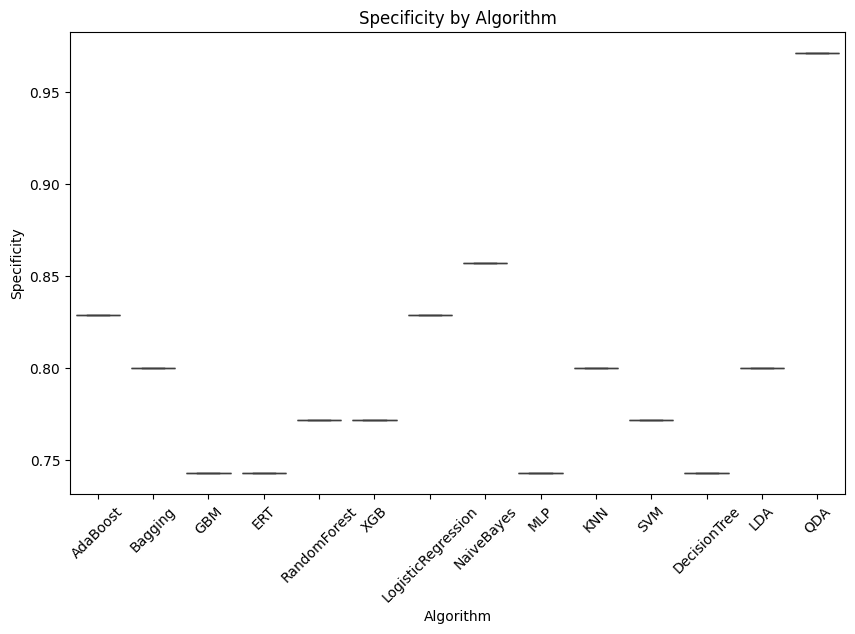

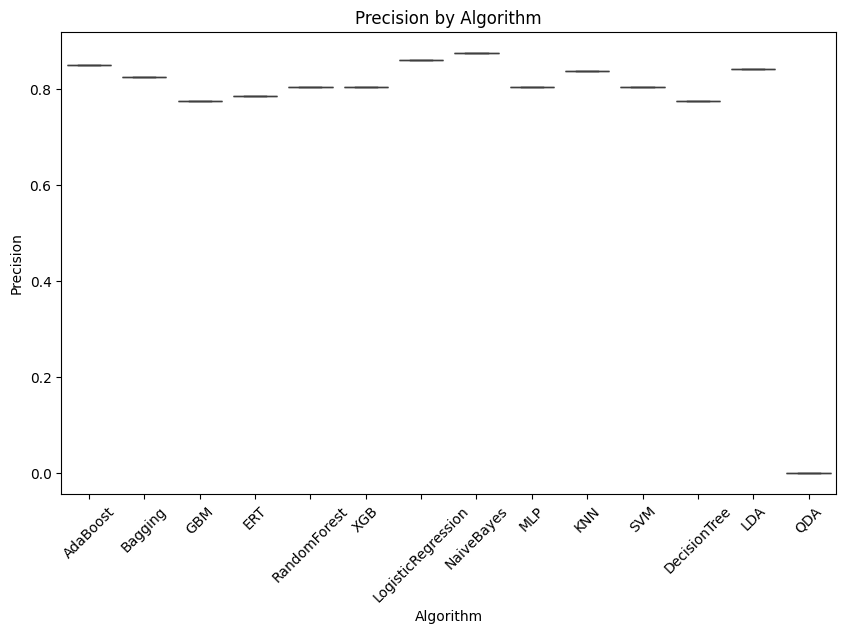

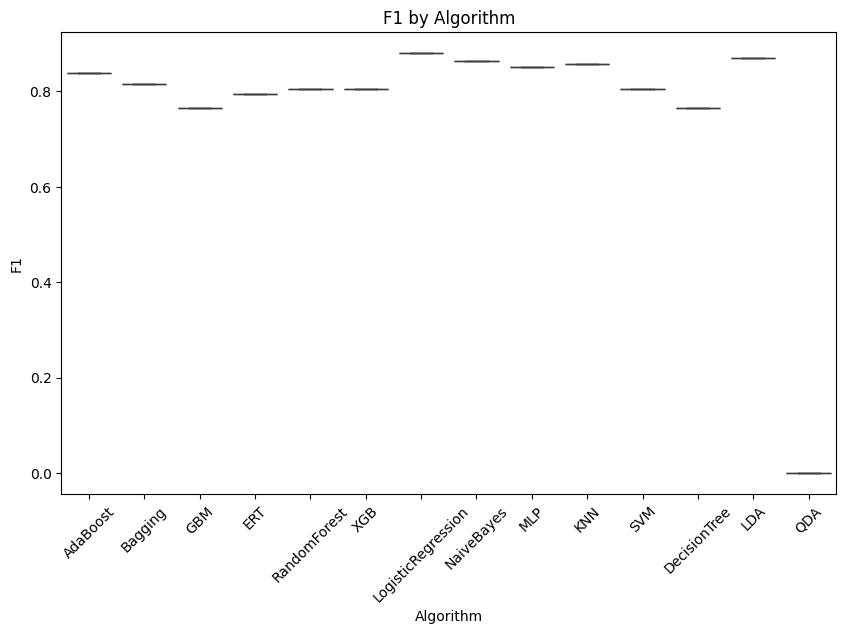

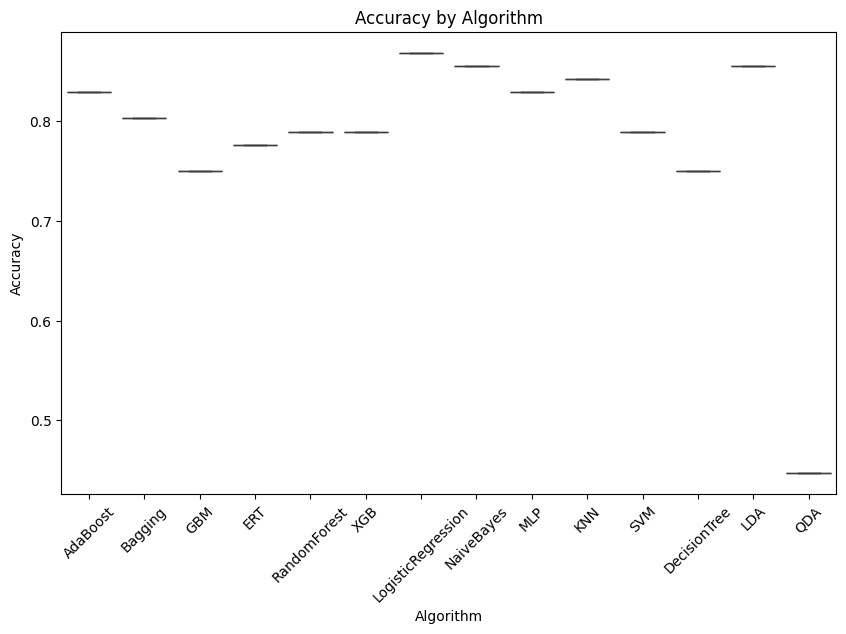

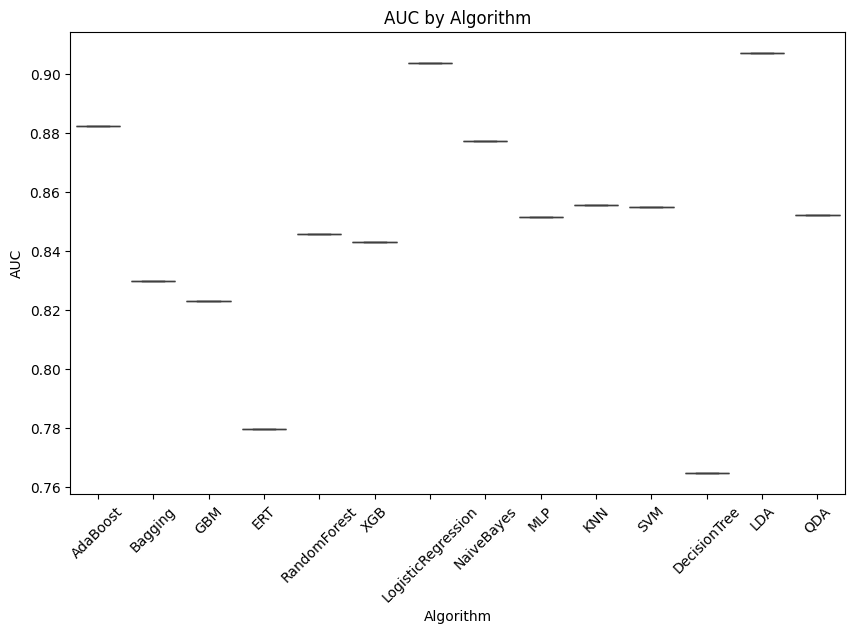

In [26]:
# Paso 2: Carga de datos y preprocesamiento
df = pd.read_csv("heart.csv")

# Convertir columnas a categóricas
categorical_columns = ['sex', 'cp', 'fbs', 'exang', 'restecg', 'slope', 'thal', 'target']
df[categorical_columns] = df[categorical_columns].astype('category')

# Renombrar niveles
df['sex'] = df['sex'].cat.rename_categories({0: 'Female', 1: 'Male'})
df['fbs'] = df['fbs'].cat.rename_categories({0: 'Fasting Blood Sugar <= 120', 1: 'Fasting Blood Sugar > 120'})
df['thal'] = df['thal'].cat.rename_categories({0: 'No Thalassemia', 1: 'Normal Thalassemia', 2: 'Fixed Defect Thalassemia', 3: 'Reversible Defect Thalassemia'})
df['target'] = df['target'].cat.rename_categories({0: 'Healthy', 1: 'Heart Disease'})
df['exang'] = df['exang'].cat.rename_categories({1: 'Exercise Induced Angina', 0: 'No Exercise Induced Angina'})
df['cp'] = df['cp'].cat.rename_categories({0: 'Chest Pain Type 0', 1: 'Chest Pain Type 1', 2: 'Chest Pain Type 2', 3: 'Chest Pain Type 3'})
df['restecg'] = df['restecg'].cat.rename_categories({0: 'Rest ECG 0', 1: 'Rest ECG 1', 2: 'Rest ECG 2'})
df['slope'] = df['slope'].cat.rename_categories({0: 'Peak Excercise ST Slope 0', 1: 'Peak Excercise ST Slope 1', 2: 'Peak Excercise ST Slope 2'})

# Copia para visualización
df_vis = df.copy()

# Variables seleccionadas
best_33 = ['cp', 'thal', 'ca', 'oldpeak', 'target']
df = df[best_33]

#Paso 3 convertir target a numerico 

df['target'] = df['target'].astype('category').cat.codes

# One-hot y división
y = df['target']
X = pd.get_dummies(df.drop('target', axis=1), drop_first=True).astype('float64')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

# Paso 4: Métricas
def metricas(model, model_label, X_train, X_valid, y_train, y_valid):
    y_pred = model.predict(X_valid)
    try:
        y_pred_prob = model.predict_proba(X_valid)[:, 1]
    except AttributeError:
        y_pred_prob = y_pred

    cm = confusion_matrix(y_valid, y_pred)
    sensitivity = recall_score(y_valid, y_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    accuracy = accuracy_score(y_valid, y_pred)
    try:
        auc = roc_auc_score(y_valid, y_pred_prob)
    except:
        auc = np.nan

    return {
        'Algorithm': model_label,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'F1': f1,
        'Accuracy': accuracy,
        'AUC': auc
    }

# Paso 5: Modelos
models = {
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'GBM': GradientBoostingClassifier(),
    'ERT': ExtraTreesClassifier(),# Nuevo
    'RandomForest': RandomForestClassifier(),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'DecisionTree': DecisionTreeClassifier(),#nuevo
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()    
}

# Entrenar modelos
results = []
X_train_np = np.ascontiguousarray(X_train.values)
X_valid_np = np.ascontiguousarray(X_valid.values)

for model_label, model in models.items():
    model.fit(X_train_np, y_train)
    result = metricas(model, model_label, X_train_np, X_valid_np, y_train, y_valid)
    results.append(result)

df_results = pd.DataFrame(results)

# Paso 6: Visualización
metrics = ['Sensitivity', 'Specificity', 'Precision', 'F1', 'Accuracy', 'AUC']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Algorithm', y=metric, data=df_results)
    plt.title(f'{metric} by Algorithm')
    plt.xticks(rotation=45)
    plt.show()


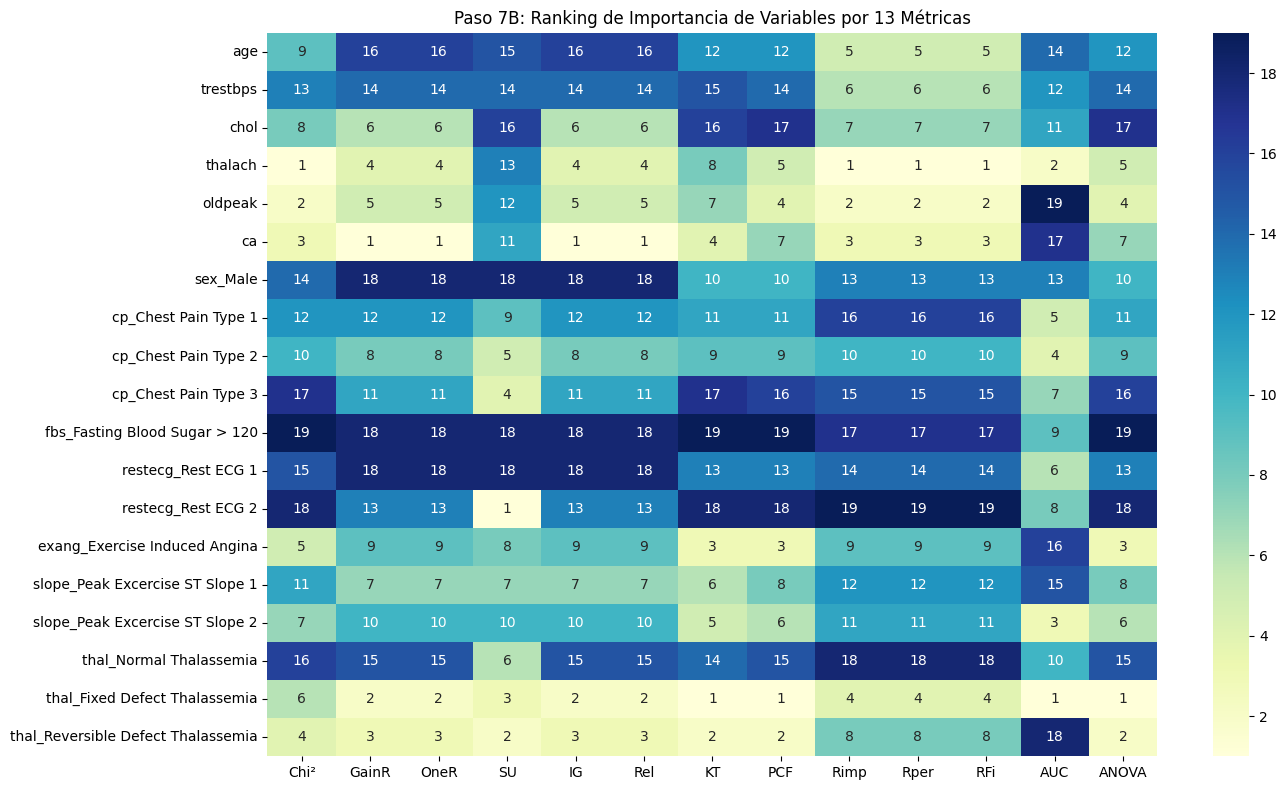

                                    Chi²  GainR  OneR    SU    IG   Rel    KT  \
thal_Fixed Defect Thalassemia        6.0    2.0   2.0   3.0   2.0   2.0   1.0   
thalach                              1.0    4.0   4.0  13.0   4.0   4.0   8.0   
ca                                   3.0    1.0   1.0  11.0   1.0   1.0   4.0   
thal_Reversible Defect Thalassemia   4.0    3.0   3.0   2.0   3.0   3.0   2.0   
oldpeak                              2.0    5.0   5.0  12.0   5.0   5.0   7.0   
exang_Exercise Induced Angina        5.0    9.0   9.0   8.0   9.0   9.0   3.0   
cp_Chest Pain Type 2                10.0    8.0   8.0   5.0   8.0   8.0   9.0   
slope_Peak Excercise ST Slope 2      7.0   10.0  10.0  10.0  10.0  10.0   5.0   
slope_Peak Excercise ST Slope 1     11.0    7.0   7.0   7.0   7.0   7.0   6.0   
chol                                 8.0    6.0   6.0  16.0   6.0   6.0  16.0   
age                                  9.0   16.0  16.0  15.0  16.0  16.0  12.0   
cp_Chest Pain Type 1        

In [27]:
# Paso 7 Importancia de las caracteristicas 


# Preparar datos desde df_vis (con target codificado)
df_importancia = df_vis.copy()
df_importancia['target'] = df_importancia['target'].astype('category').cat.codes

X_imp = pd.get_dummies(df_importancia.drop('target', axis=1), drop_first=True).astype('float64')
y_imp = df_importancia['target']

# Métricas base
chi2_vals, _ = chi2(X_imp, y_imp)
mi_vals = mutual_info_classif(X_imp, y_imp)
anova_vals, _ = f_classif(X_imp, y_imp)

# Random Forest Importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_imp, y_imp)
rfi_vals = rf.feature_importances_

# AUC por variable
auc_vals = []
for col in X_imp.columns:
    try:
        auc = roc_auc_score(y_imp, X_imp[col])
    except:
        auc = np.nan
    auc_vals.append(auc)

# Kendall Tau
kt_vals = [abs(kendalltau(X_imp[col], y_imp).correlation) for col in X_imp.columns]

# PCF (punto biserial)
pcf_vals = [abs(pointbiserialr(X_imp[col], y_imp)[0]) for col in X_imp.columns]

# Aproximaciones para GainR, OneR, SU, Rel, Rimp, Rper
# Utilizamos MI como proxy, SU se normaliza por varianza
gainr_vals = mi_vals
oner_vals = mi_vals
su_vals = mi_vals / (X_imp.var().values + 1e-6)
rel_vals = mi_vals
rimp_vals = rfi_vals
rper_vals = rfi_vals

# Compilar en DataFrame
importancia_df = pd.DataFrame({
    'Chi²': chi2_vals,
    'GainR': gainr_vals,
    'OneR': oner_vals,
    'SU': su_vals,
    'IG': mi_vals,
    'Rel': rel_vals,
    'KT': kt_vals,
    'PCF': pcf_vals,
    'Rimp': rimp_vals,
    'Rper': rper_vals,
    'RFi': rfi_vals,
    'AUC': auc_vals,
    'ANOVA': anova_vals
}, index=X_imp.columns)

#Paso 7B: Cálculo de 13 métricas de importancia y ranking final
# Calcular rankings
ranking_df = importancia_df.rank(ascending=False)
ranking_df['Mean'] = ranking_df.mean(axis=1)
ranking_df['Rank'] = ranking_df['Mean'].rank()

# Exportar a CSV
output_path = "C:/Users/americasys\Documents/Doctorado/1. Documento Doctorado/Documento T/Codigo documentado/ranking_importancia_metricas.csv"
ranking_df.sort_values("Rank").to_csv(output_path)

# Visualización
plt.figure(figsize=(14, 8))
sns.heatmap(ranking_df.iloc[:, :-2], annot=True, cmap='YlGnBu')
plt.title("Paso 7B: Ranking de Importancia de Variables por 13 Métricas")
plt.tight_layout()
plt.show()

# Mostrar tabla ordenada por importancia
print(ranking_df.sort_values("Rank"))


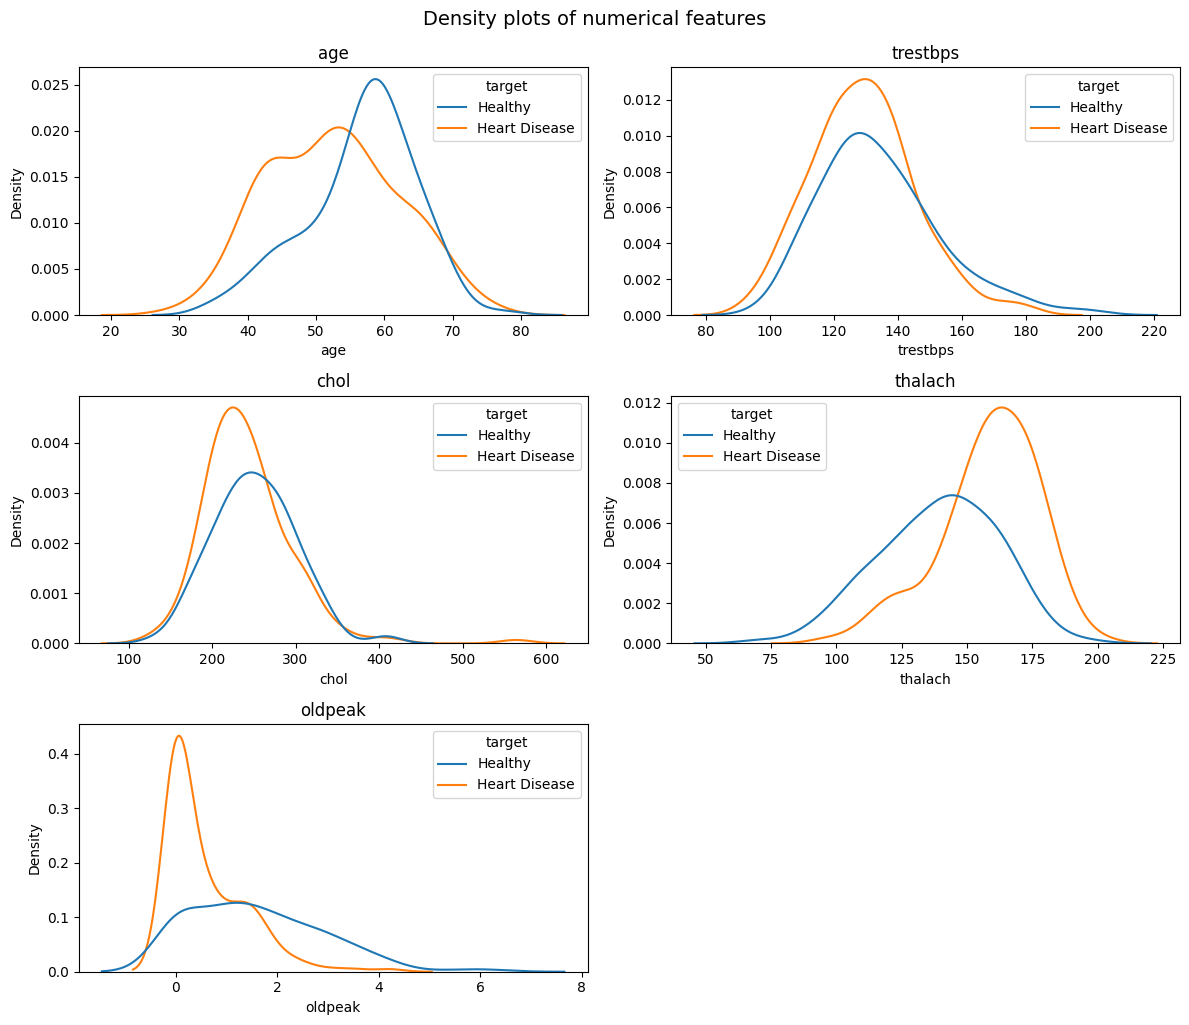

In [28]:
# Paso 7C: Gráficos de densidad de variables numéricas por clase

numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

plt.figure(figsize=(12, 10))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(data=df_vis, x=col, hue='target', fill=False)
    plt.title(col)

plt.tight_layout()
plt.suptitle("Density plots of numerical features", fontsize=14, y=1.02)
plt.show()


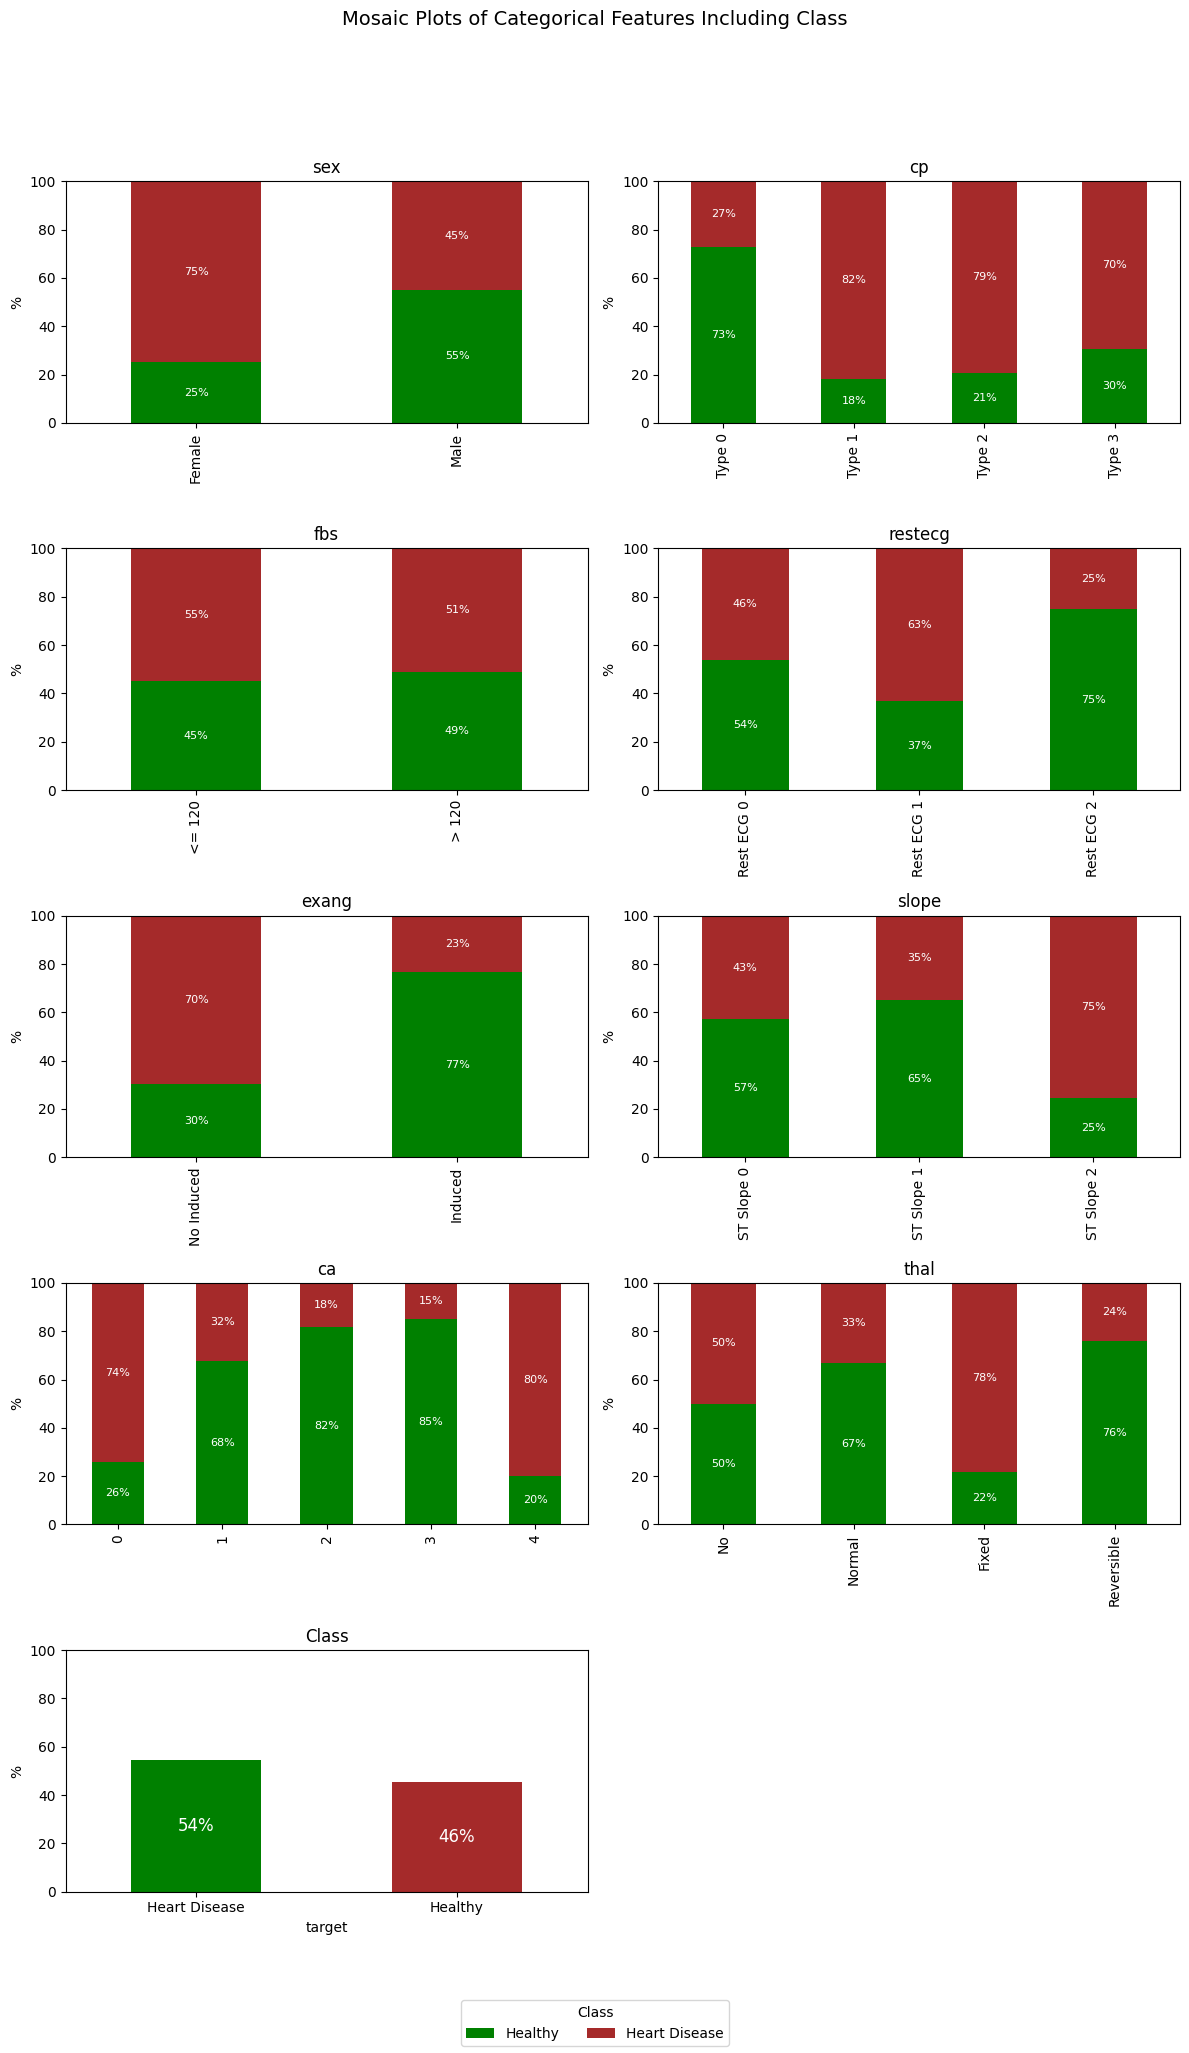

In [29]:
# Paso 7D: Gráficos de mosaico para variables categóricas incluyendo Class

# Recargar datos para asegurar que existan las columnas originales
categorical_columns_mosaic = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
df_mosaic = pd.read_csv("heart.csv")
df_mosaic[categorical_columns_mosaic] = df_mosaic[categorical_columns_mosaic].astype('category')


# Renombrar niveles

try:
    df_mosaic['sex'] = df_mosaic['sex'].cat.rename_categories({0: 'Female', 1: 'Male'})
    df_mosaic['fbs'] = df_mosaic['fbs'].cat.rename_categories({0: '<= 120', 1: '> 120'})
    df_mosaic['thal'] = df_mosaic['thal'].cat.rename_categories({0: 'No', 1: 'Normal', 2: 'Fixed', 3: 'Reversible'})
    df_mosaic['target'] = df_mosaic['target'].cat.rename_categories({0: 'Healthy', 1: 'Heart Disease'})
    df_mosaic['exang'] = df_mosaic['exang'].cat.rename_categories({0: 'No Induced', 1: 'Induced'})
    df_mosaic['cp'] = df_mosaic['cp'].cat.rename_categories({0: 'Type 0', 1: 'Type 1', 2: 'Type 2', 3: 'Type 3'})
    df_mosaic['restecg'] = df_mosaic['restecg'].cat.rename_categories({0: 'Rest ECG 0', 1: 'Rest ECG 1', 2: 'Rest ECG 2'})
    df_mosaic['slope'] = df_mosaic['slope'].cat.rename_categories({0: 'ST Slope 0', 1: 'ST Slope 1', 2: 'ST Slope 2'})
except:
    pass

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 20))
axes = axes.flatten()

all_categories = categorical_columns_mosaic

for i, col in enumerate(all_categories):
    ax = axes[i]
    if col != 'target':
        prop_df = pd.crosstab(df_mosaic[col], df_mosaic['target'], normalize='index') * 100
        prop_df.plot(kind='bar', stacked=True, ax=ax, color=['green', 'brown'], legend=False)
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.text(p.get_x() + p.get_width() / 2., p.get_y() + height / 2.,
                        f'{height:.0f}%', ha="center", va="center", color='white', fontsize=8)
        ax.set_title(col)
        ax.set_ylabel('%')
        ax.set_xlabel('')
        ax.set_ylim(0, 100)
    else:
        class_counts = df_mosaic['target'].value_counts(normalize=True) * 100
        class_counts.plot(kind='bar', color=['green', 'brown'], ax=ax)
        for j, v in enumerate(class_counts):
            ax.text(j, v / 2, f'{v:.0f}%', ha='center', va='center', color='white', fontsize=12)
        ax.set_title("Class")
        ax.set_ylabel('%')
        ax.set_xticklabels(class_counts.index, rotation=0)
        ax.set_ylim(0, 100)

for j in range(len(all_categories), len(axes)):
    fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Class", loc='lower center', ncol=2)
plt.suptitle('Mosaic Plots of Categorical Features Including Class', fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.show()


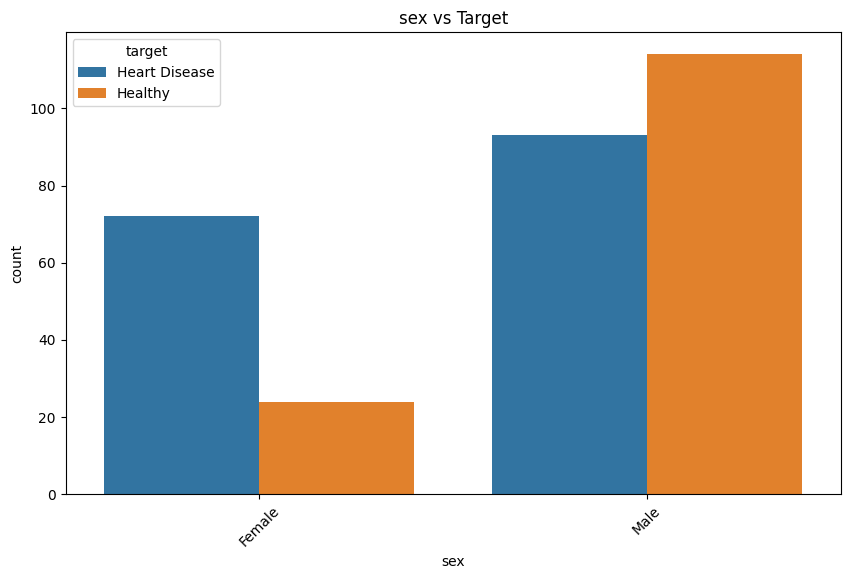

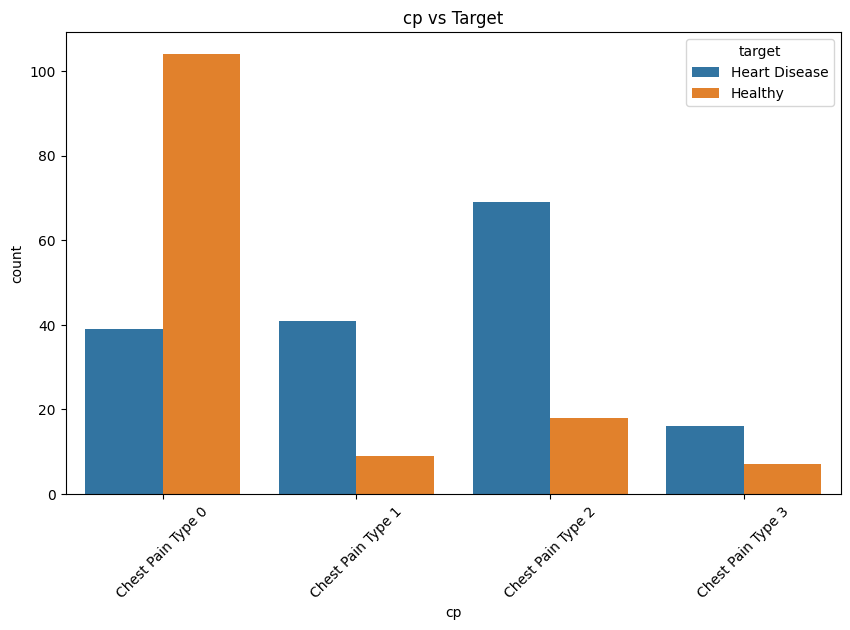

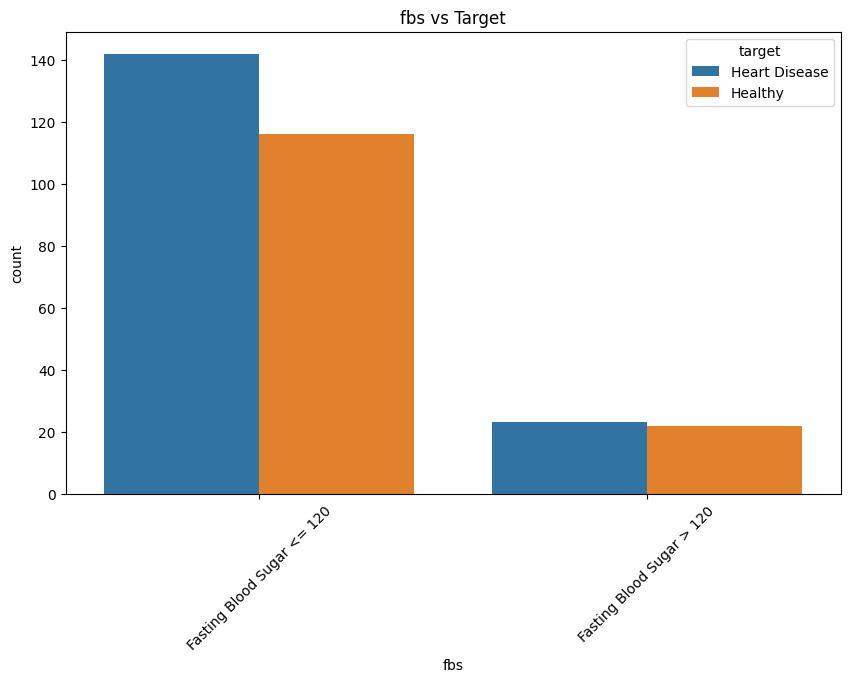

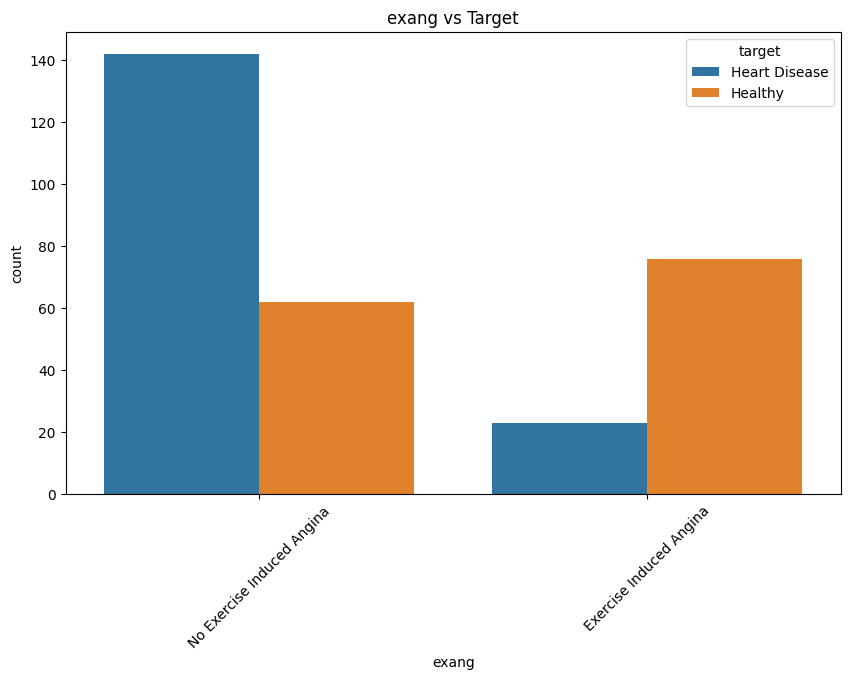

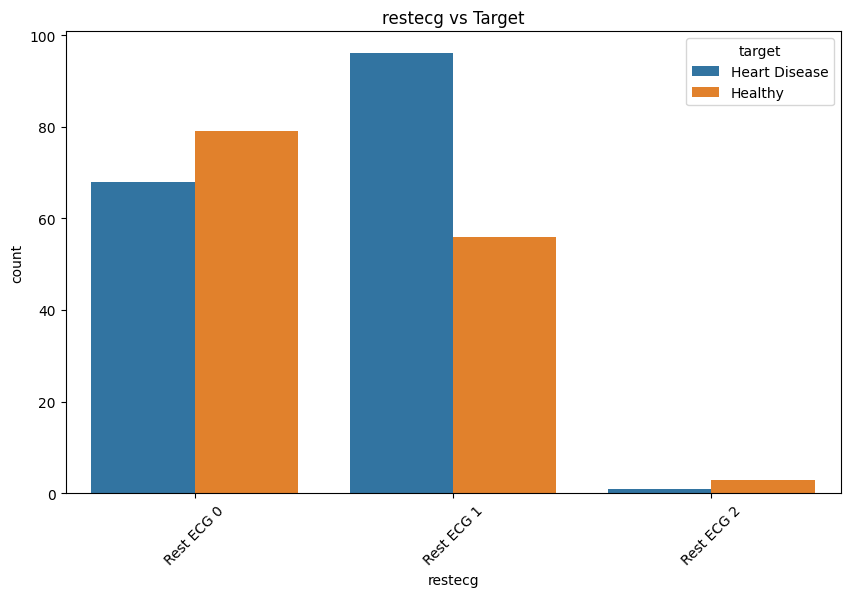

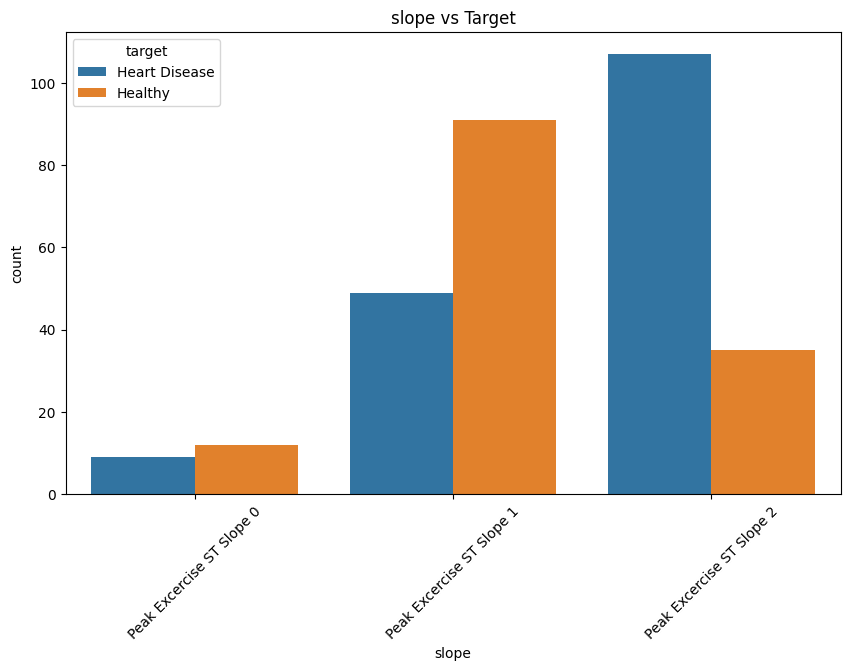

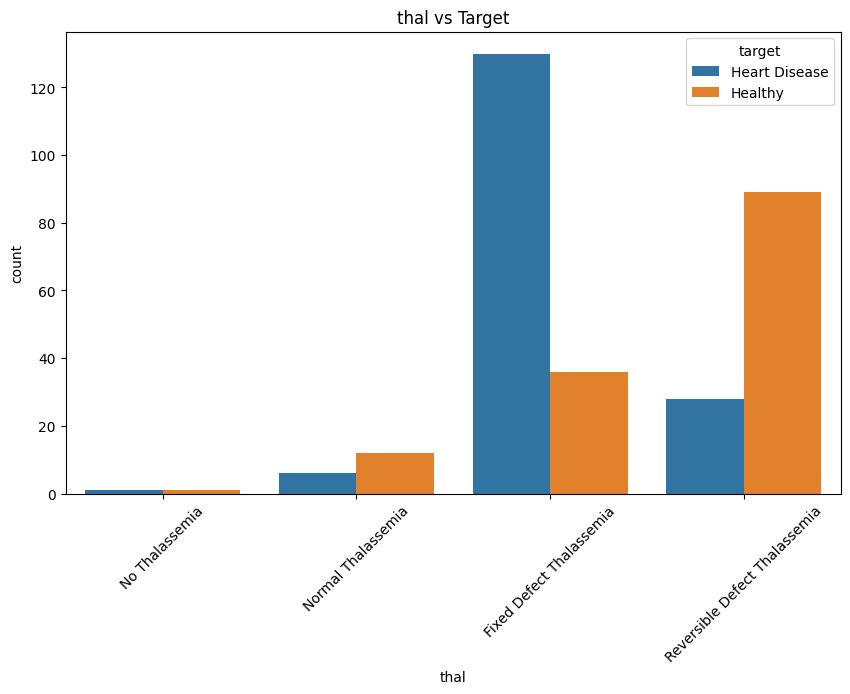

In [30]:
# Paso 8: Gráficos de variables pvs target 
df_vis['target'] = df_vis['target'].astype(str)
for col in categorical_columns:
    if col != 'target':
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, hue='target', data=df_vis)
        plt.title(f'{col} vs Target')
        plt.xticks(rotation=45)
        plt.show()


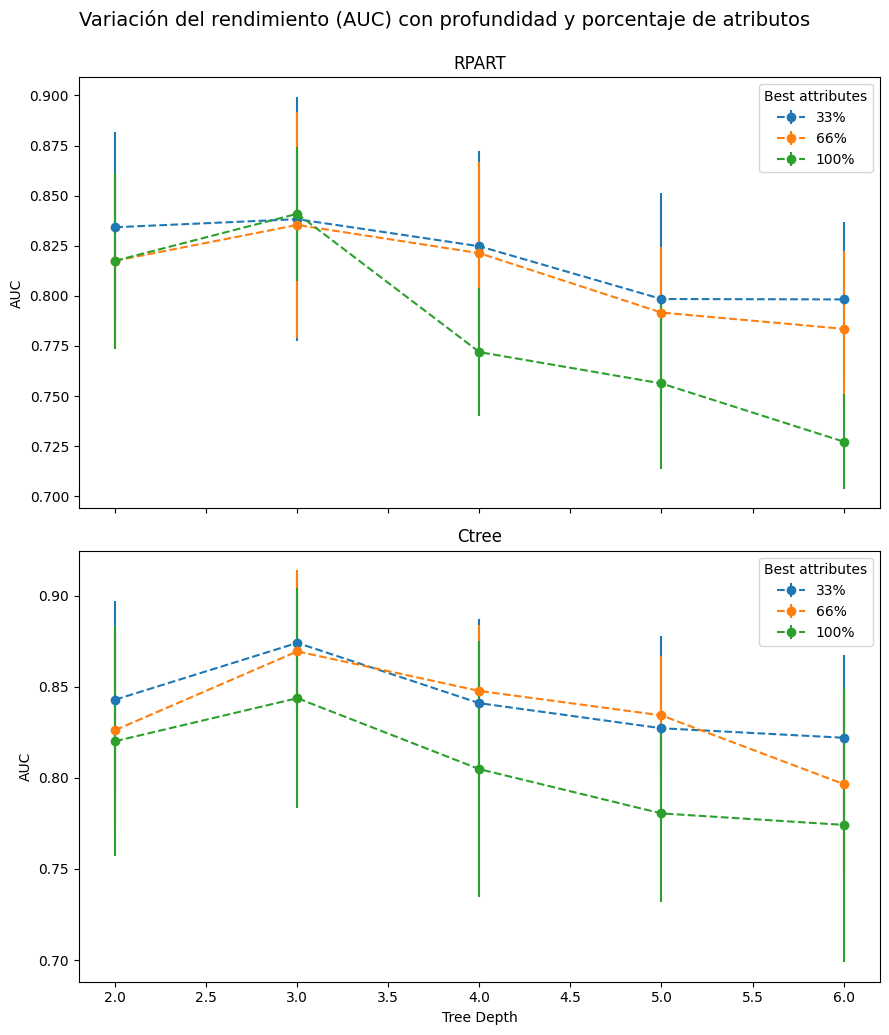

In [31]:
#paso 8.1: rendimiento (AUC) con profundidad y porcentaje de atributos
# Subconjuntos definidos
best_33 = ['cp', 'thal', 'ca', 'oldpeak', 'target']
best_66 = ['cp', 'thal', 'ca', 'oldpeak', 'thalach', 'exang', 'slope', 'sex', 'target']

df_33 = df_vis[best_33]
df_66 = df_vis[best_66]
df_100 = df_vis.copy()

attribute_sets = {
    '33%': df_33,
    '66%': df_66,
    '100%': df_100
}

depths = [2, 3, 4, 5, 6]
results_rpart = []
results_ctree = []

for name, dataset in attribute_sets.items():
    X = pd.get_dummies(dataset.drop('target', axis=1), drop_first=True).astype('float64')
    y = dataset['target'].astype('category').cat.codes

    for depth in depths:
        # RPART (gini)
        rpart = DecisionTreeClassifier(max_depth=depth, criterion='gini', random_state=42)
        rpart_scores = cross_val_score(rpart, X, y, cv=5, scoring='roc_auc')
        results_rpart.append({
            'Subset': name,
            'Depth': depth,
            'AUC': np.mean(rpart_scores),
            'Std': np.std(rpart_scores)
        })

        # Ctree (entropy)
        ctree = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
        ctree_scores = cross_val_score(ctree, X, y, cv=5, scoring='roc_auc')
        results_ctree.append({
            'Subset': name,
            'Depth': depth,
            'AUC': np.mean(ctree_scores),
            'Std': np.std(ctree_scores)
        })

rpart_df = pd.DataFrame(results_rpart)
ctree_df = pd.DataFrame(results_ctree)

# Gráfica final
fig, axes = plt.subplots(2, 1, figsize=(9, 10), sharex=True)

for subset in rpart_df['Subset'].unique():
    data = rpart_df[rpart_df['Subset'] == subset]
    axes[0].errorbar(data['Depth'], data['AUC'], yerr=data['Std'], label=subset,
                     linestyle='dashed', marker='o')
axes[0].set_title("RPART")
axes[0].set_ylabel("AUC")
axes[0].legend(title="Best attributes")

for subset in ctree_df['Subset'].unique():
    data = ctree_df[ctree_df['Subset'] == subset]
    axes[1].errorbar(data['Depth'], data['AUC'], yerr=data['Std'], label=subset,
                     linestyle='dashed', marker='o')
axes[1].set_title("Ctree")
axes[1].set_xlabel("Tree Depth")
axes[1].set_ylabel("AUC")
axes[1].legend(title="Best attributes")

plt.tight_layout()
plt.suptitle("Variación del rendimiento (AUC) con profundidad y porcentaje de atributos", fontsize=14, y=1.03)
plt.show()



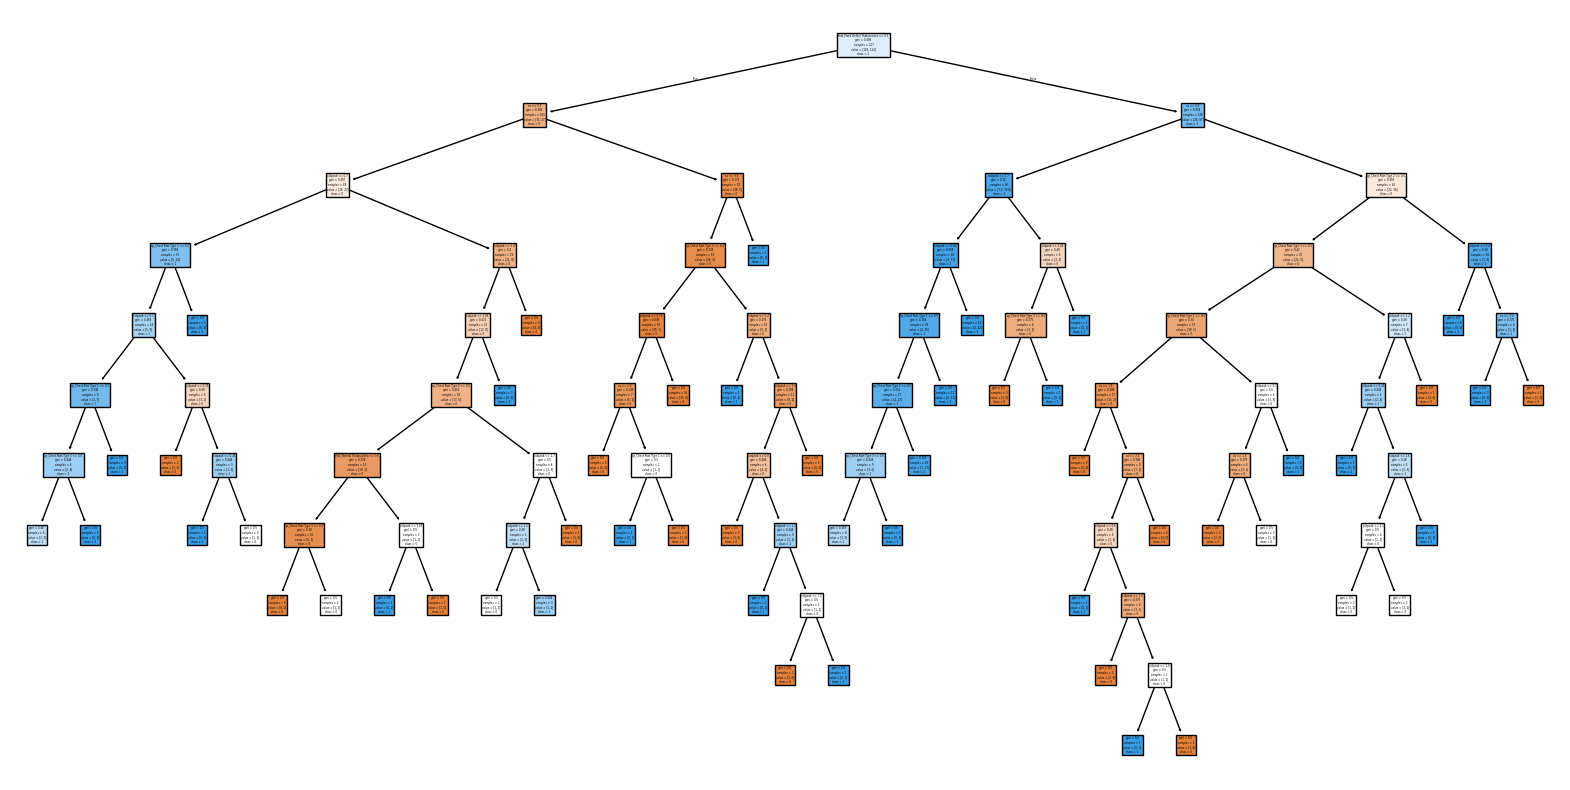

In [32]:
# Paso 9: Árbol de decisión
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=list(X_train.columns), class_names=['0', '1'])
plt.show()

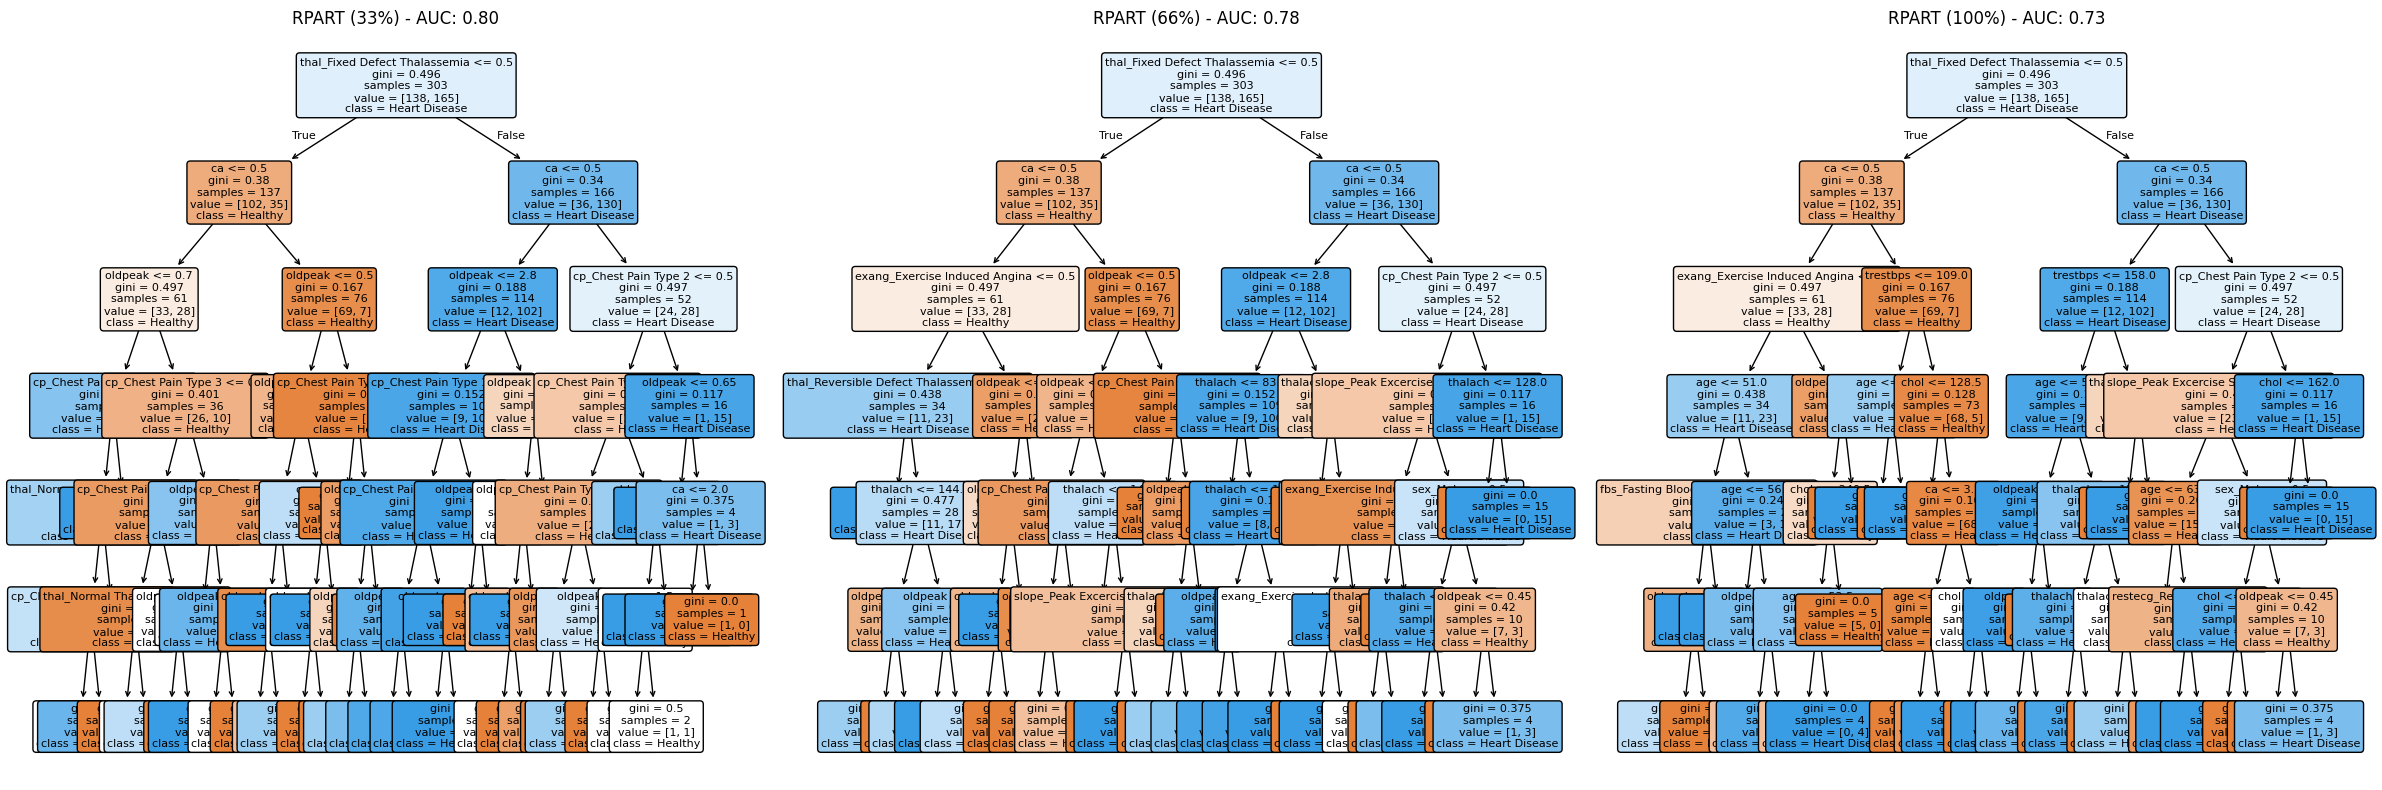

In [33]:
#Paso 9.1 Visualización de RPART con 33%, 66% y 100% de características (max_depth=6)


fig, axes = plt.subplots(1, 3, figsize=(24, 8))
attribute_sets = {
    '33%': df_33,
    '66%': df_66,
    '100%': df_100
}

rpart_auc_scores = {}

for ax, (name, dataset) in zip(axes, attribute_sets.items()):
    X = pd.get_dummies(dataset.drop('target', axis=1), drop_first=True).astype('float64')
    y = dataset['target'].astype('category').cat.codes

    model = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
    model.fit(X, y)

    auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc').mean()
    rpart_auc_scores[name] = auc

    plot_tree(
        model,
        feature_names=list(X.columns),
        class_names=['Healthy', 'Heart Disease'],
        filled=True,
        rounded=True,
        fontsize=8,
        ax=ax
    )
    ax.set_title(f"RPART ({name}) - AUC: {auc:.2f}")

plt.tight_layout()
plt.show()



In [34]:
from sklearn.tree import export_graphviz
import graphviz

# 33%
X_33 = pd.get_dummies(df_33.drop('target', axis=1), drop_first=True).astype('float64')
y_33 = df_33['target'].astype('category').cat.codes

model_33 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_33.fit(X_33, y_33)

dot_data_33 = export_graphviz(
    model_33,
    out_file=None,
    feature_names=X_33.columns,
    class_names=['Healthy', 'Heart Disease'],
    filled=True,
    rounded=True,
    special_characters=True
)

graph_33 = graphviz.Source(dot_data_33)
graph_33.render("tree_33", format="png", cleanup=False)  # Exporta como PNG
graph_33.view()

'tree_33.pdf'

In [35]:
# 66%
X_66 = pd.get_dummies(df_66.drop('target', axis=1), drop_first=True).astype('float64')
y_66 = df_66['target'].astype('category').cat.codes

model_66 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_66.fit(X_66, y_66)

dot_data_66 = export_graphviz(
    model_66,
    out_file=None,
    feature_names=X_66.columns,
    class_names=['Healthy', 'Heart Disease'],
    filled=True,
    rounded=True,
    special_characters=True
)

graph_66 = graphviz.Source(dot_data_66)
graph_66.render("tree_66", format="png", cleanup=False)
graph_66.view()

'tree_66.pdf'

In [36]:
from sklearn.tree import export_graphviz
import graphviz

# 100%
X_100 = pd.get_dummies(df_100.drop('target', axis=1), drop_first=True).astype('float64')
y_100 = df_100['target'].astype('category').cat.codes

# Reemplazar caracteres conflictivos en nombres de columnas
X_100.columns = X_100.columns.str.replace("&", "and").str.replace(">", "gt").str.replace("<", "lt")

model_100 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_100.fit(X_100, y_100)

dot_data_100 = export_graphviz(
    model_100,
    out_file=None,
    feature_names=X_100.columns,
    class_names=['Healthy', 'Heart Disease'],
    filled=True,
    rounded=True,
    special_characters=True
)

graph_100 = graphviz.Source(dot_data_100)
graph_100.render("tree_100", format="png", cleanup=False)
graph_100.view()

'tree_100.pdf'

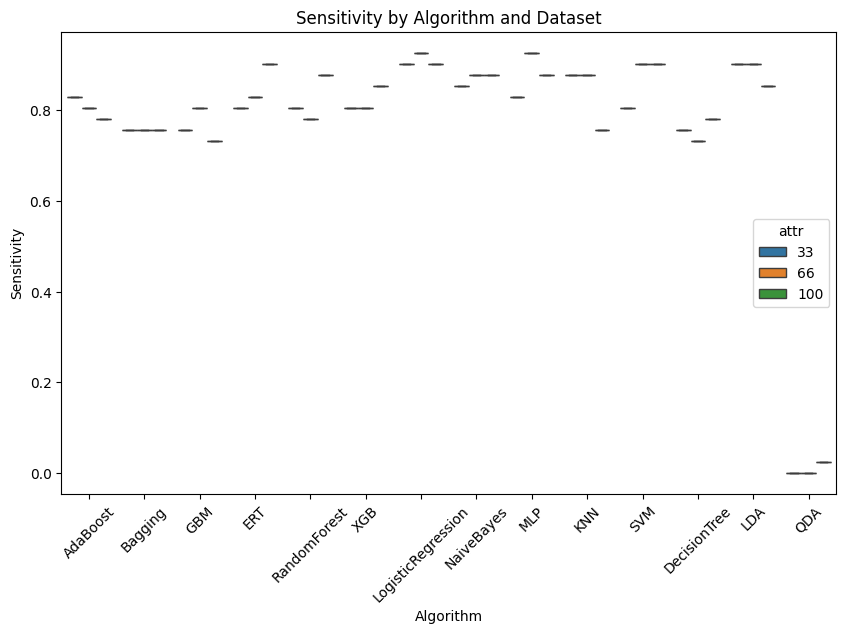

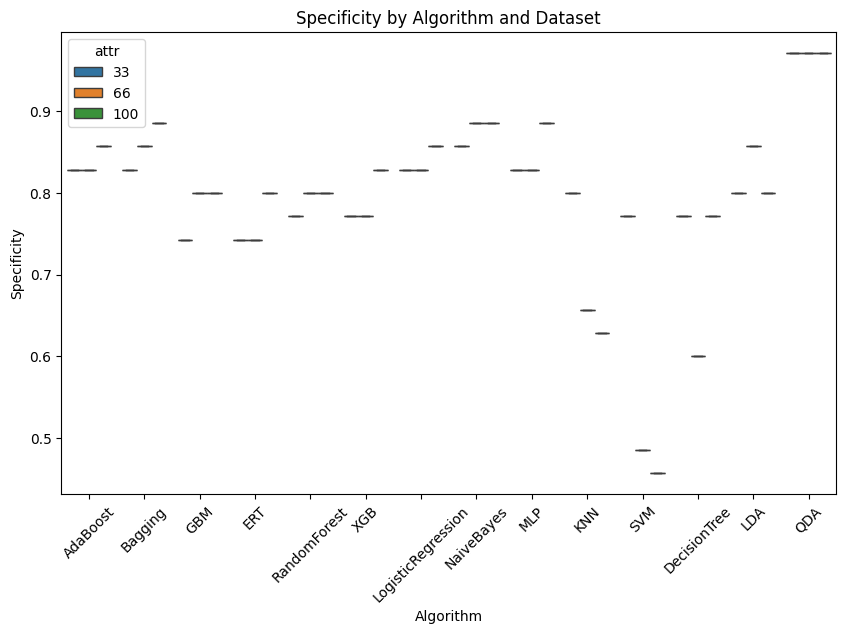

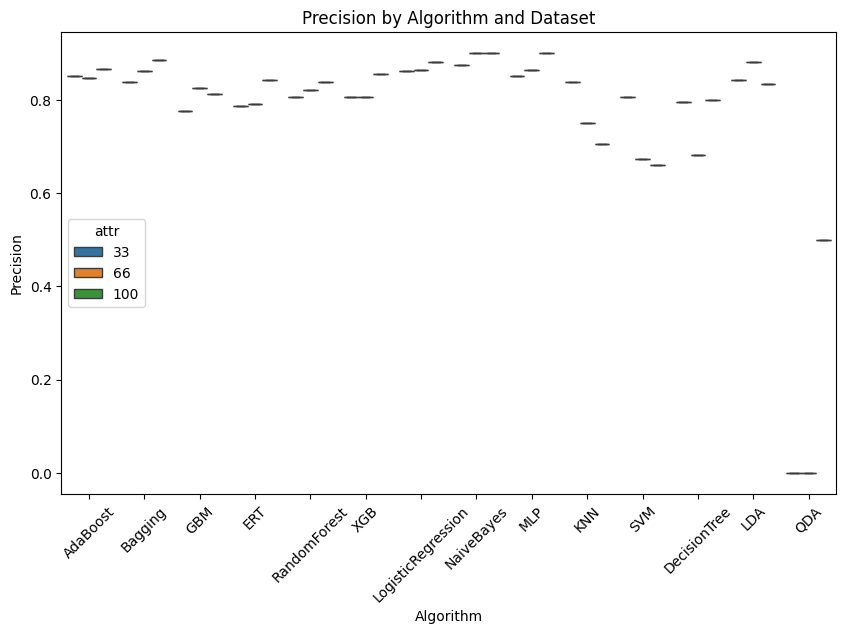

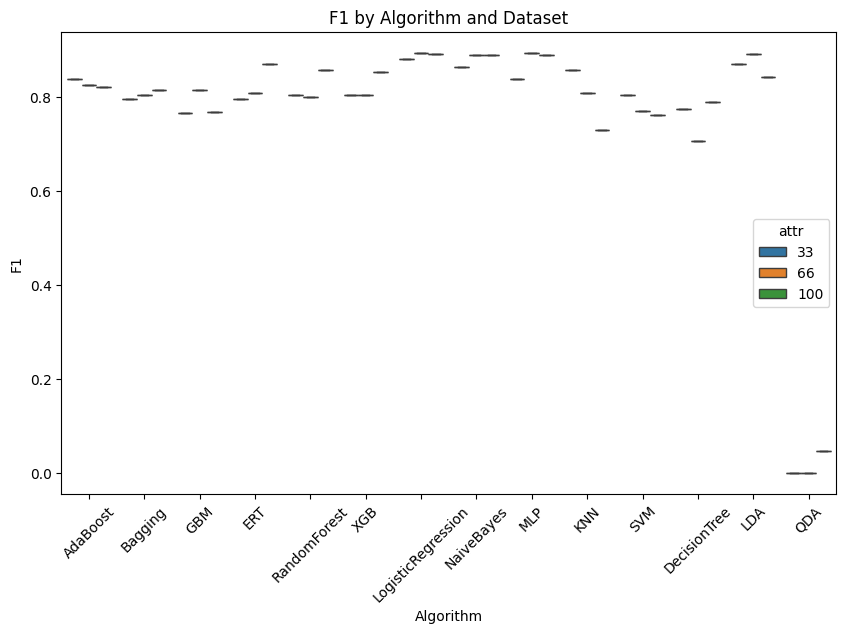

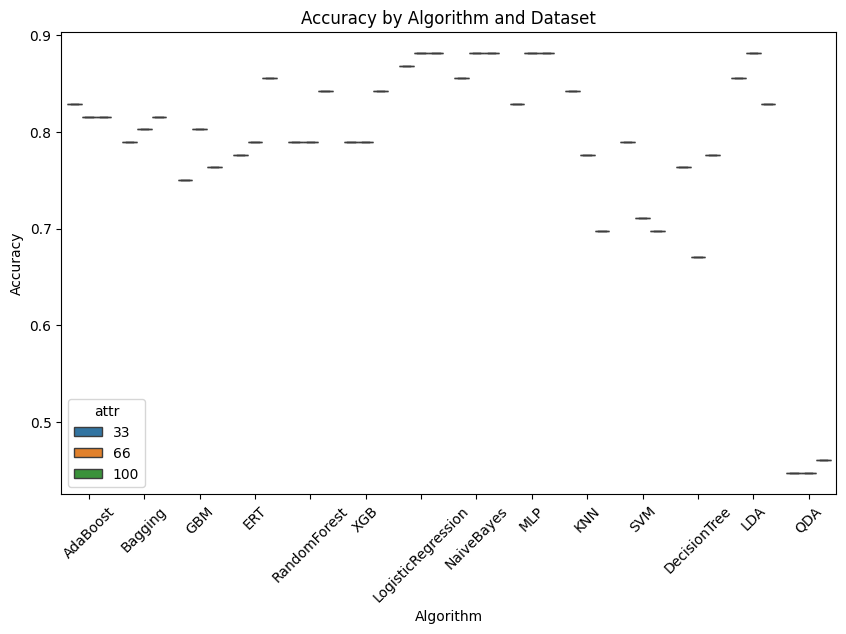

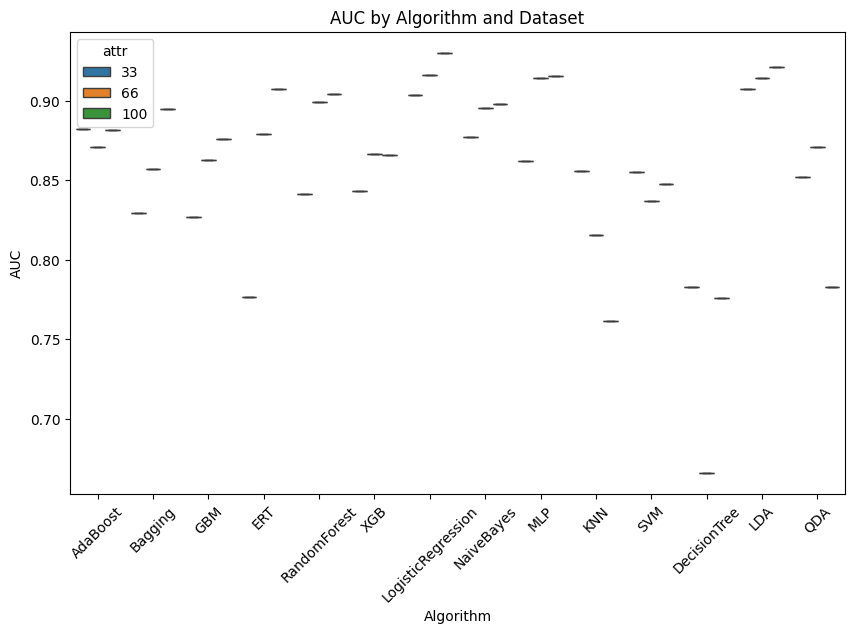

In [37]:
# Paso 10: Evaluación con conjuntos de datos distintos
df_33 = df_vis[best_33]
df_66 = df_vis[['cp', 'thal', 'ca', 'oldpeak', 'thalach', 'exang', 'slope', 'sex', 'target']]
df_100 = df_vis

datasets = {'33': df_33, '66': df_66, '100': df_100}
results_all = []

for name, dataset in datasets.items():
    X = pd.get_dummies(dataset.drop('target', axis=1), drop_first=True).astype('float64')
    y = dataset['target'].astype('category').cat.codes

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

    X_train_np = np.ascontiguousarray(X_train.values)
    X_valid_np = np.ascontiguousarray(X_valid.values)

    for model_label, model in models.items():
        model.fit(X_train_np, y_train)
        result = metricas(model, model_label, X_train_np, X_valid_np, y_train, y_valid)
        result['attr'] = name
        results_all.append(result)

df_results_all = pd.DataFrame(results_all)

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Algorithm', y=metric, hue='attr', data=df_results_all)
    plt.title(f'{metric} by Algorithm and Dataset')
    plt.xticks(rotation=45)
    plt.show()

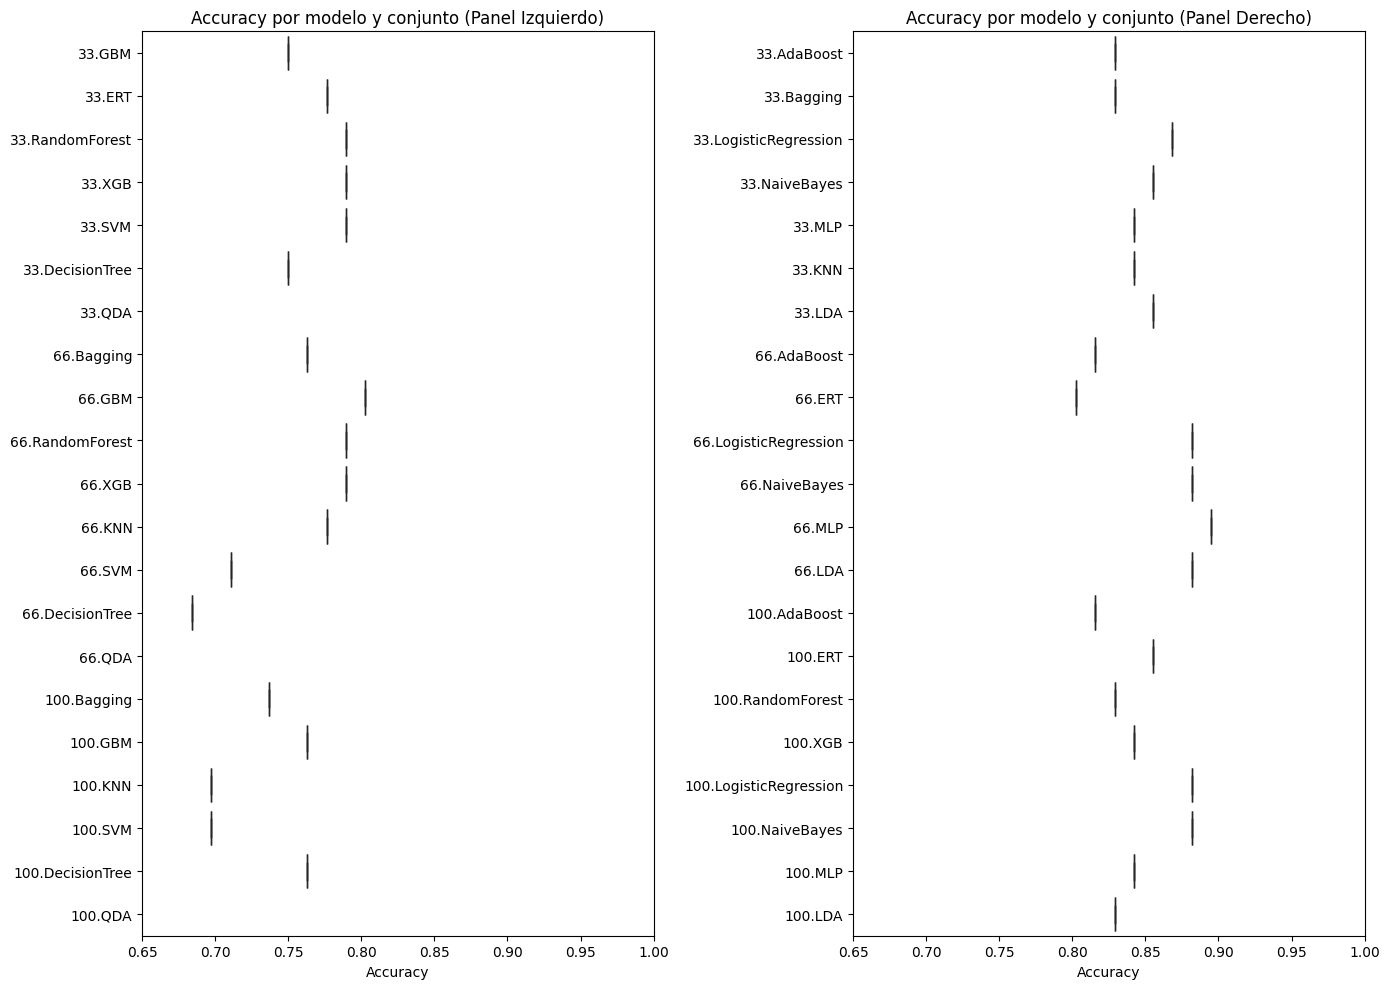

In [38]:
# Paso 10.1: Evaluación con conjuntos de datos distintos y visualización de Accuracy tipo boxplot

df_33 = df_vis[best_33]
df_66 = df_vis[['cp', 'thal', 'ca', 'oldpeak', 'thalach', 'exang', 'slope', 'sex', 'target']]
df_100 = df_vis
datasets = {'33': df_33, '66': df_66, '100': df_100}

results_all = []
for name, dataset in datasets.items():
    X = pd.get_dummies(dataset.drop('target', axis=1), drop_first=True).astype('float64')
    y = dataset['target'].astype('category').cat.codes

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)
    X_train_np = np.ascontiguousarray(X_train.values)
    X_valid_np = np.ascontiguousarray(X_valid.values)

    for model_label, model in models.items():
        model.fit(X_train_np, y_train)
        result = metricas(model, model_label, X_train_np, X_valid_np, y_train, y_valid)
        result['attr'] = name
        results_all.append(result)

# Crear DataFrame consolidado
df_results_all = pd.DataFrame(results_all)

# Crear clave de algoritmo + atributo para agrupamiento visual
df_results_all['Label'] = df_results_all['attr'] + '.' + df_results_all['Algorithm']
df_results_all['Color'] = df_results_all['attr'].map({'33': 'red', '66': 'green', '100': 'blue'})

# Gráfico tipo panel como la imagen de referencia
import matplotlib.gridspec as gridspec

metric = 'Accuracy'
sorted_labels = df_results_all.groupby('Label')[metric].mean().sort_values().index

# Crear figura dividida en dos columnas
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

half = len(sorted_labels) // 2

for i, ax in enumerate(axs):
    labels = sorted_labels[half*i:half*(i+1)]
    subset = df_results_all[df_results_all['Label'].isin(labels)]
    sns.boxplot(
        data=subset,
        y='Label',
        x=metric,
        hue='attr',
        orient='h',
        ax=ax,
        palette={'33': 'red', '66': 'green', '100': 'blue'}
    )
    ax.set_xlim(0.65, 1.0)
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('')
    ax.set_title(f'Accuracy por modelo y conjunto ({"Panel Izquierdo" if i == 0 else "Panel Derecho"})')
    ax.legend_.remove()

plt.tight_layout()
plt.show()


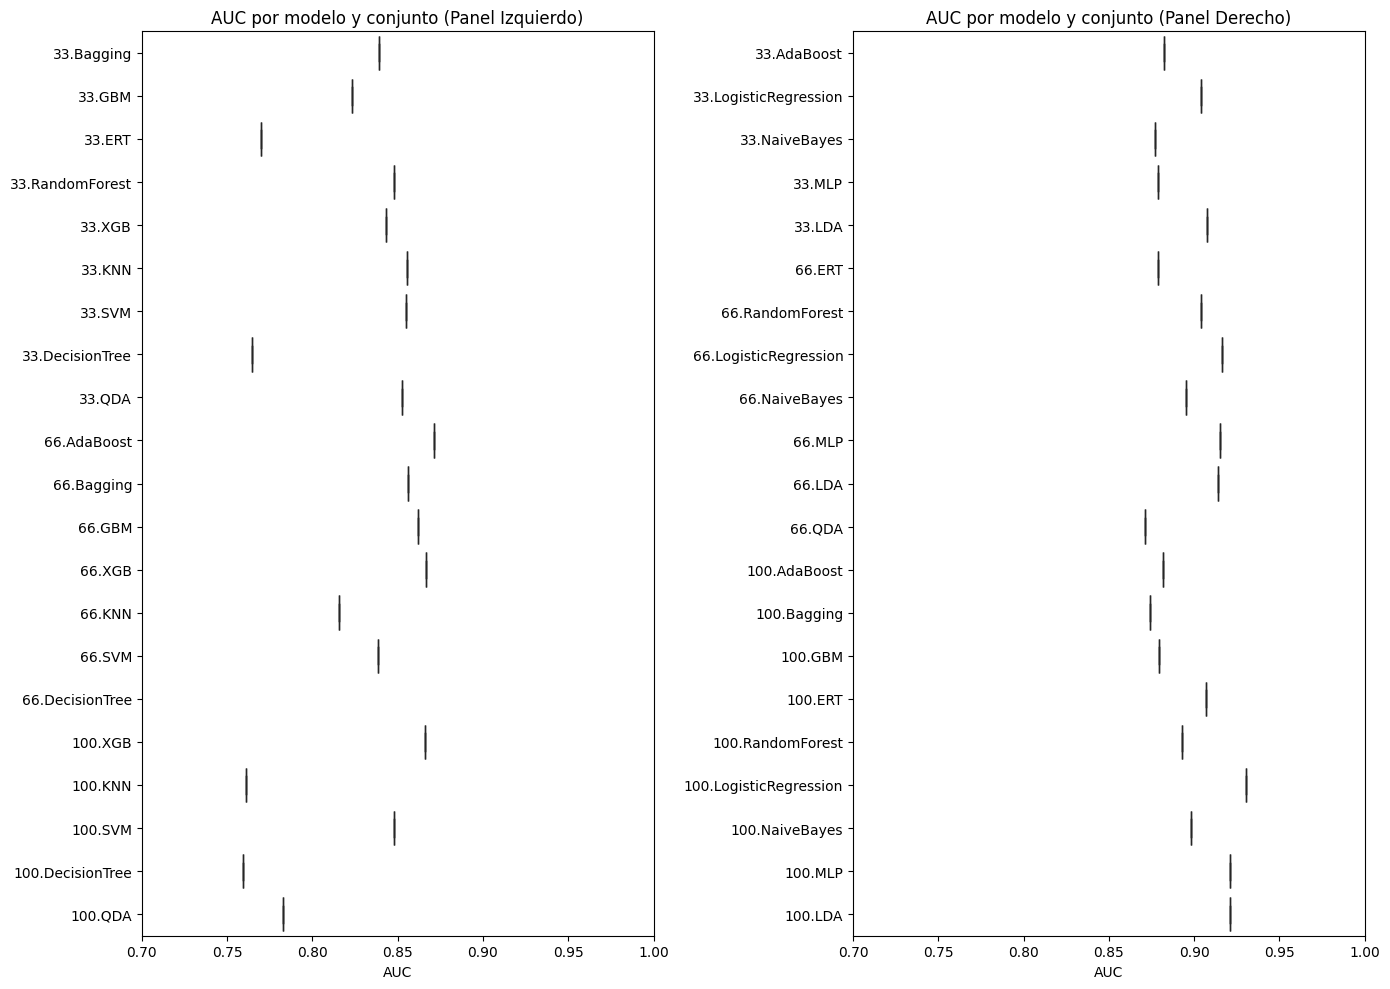

In [39]:
# Gráfico tipo panel para AUC tipo boxplot de los diferentes conjuntos de datos 
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurarse de que estas columnas estén generadas
df_results_all['Label'] = df_results_all['attr'] + '.' + df_results_all['Algorithm']
df_results_all['Color'] = df_results_all['attr'].map({'33': 'red', '66': 'green', '100': 'blue'})

# Ordenar etiquetas por AUC
metric = 'AUC'
sorted_labels = df_results_all.groupby('Label')[metric].mean().sort_values().index

# Crear figura dividida en dos columnas
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

half = len(sorted_labels) // 2

for i, ax in enumerate(axs):
    labels = sorted_labels[half*i:half*(i+1)]
    subset = df_results_all[df_results_all['Label'].isin(labels)]
    sns.boxplot(
        data=subset,
        y='Label',
        x=metric,
        hue='attr',
        orient='h',
        ax=ax,
        palette={'33': 'red', '66': 'green', '100': 'blue'}
    )
    ax.set_xlim(0.7, 1.0)
    ax.set_xlabel('AUC')
    ax.set_ylabel('')
    ax.set_title(f'AUC por modelo y conjunto ({"Panel Izquierdo" if i == 0 else "Panel Derecho"})')
    ax.legend_.remove()

plt.tight_layout()
plt.show()

## Análisis de Curvas de Rashomon y Complejidad de Modelos en HeartDisease

En esta sección se incorpora el análisis de **curvas de Rashomon**, 
la evaluación de la **complejidad del modelo**, y la representación de un **frente de Pareto** entre precisión y simplicidad del sistema.

El objetivo es observar si modelos más simples pueden alcanzar niveles similares de rendimiento y así facilitar la explicabilidad.


In [40]:
import time
import warnings
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')

# Preparar versiones del dataset con diferentes números de atributos
feature_sets = {
    'all': X.columns.tolist(),
    'top5': ranking_df.sort_values("Rank").head(5).index.tolist(),
    'top3': ranking_df.sort_values("Rank").head(3).index.tolist()
}

rashomon_results = []
epsilon = 0.01  # 1% del mejor AUC

for subset_name, features in feature_sets.items():
    X_sub = X[features]
    X_train_r, X_valid_r, y_train_r, y_valid_r = train_test_split(X_sub, y, test_size=0.25, random_state=42)

    subset_scores = []
    best_auc = 0

    for model_label, model in models.items():
        try:
            start = time.time()
            model.fit(X_train_r, y_train_r)
            train_time = time.time() - start

            y_pred = model.predict(X_valid_r)
            try:
                y_prob = model.predict_proba(X_valid_r)[:, 1]
            except:
                y_prob = y_pred

            auc = roc_auc_score(y_valid_r, y_prob)
            best_auc = max(best_auc, auc)

            if hasattr(model, 'n_estimators'):
                complexity = model.n_estimators
            elif hasattr(model, 'coef_'):
                complexity = model.coef_.shape[1]
            elif hasattr(model, 'hidden_layer_sizes'):
                complexity = sum(model.hidden_layer_sizes)
            elif hasattr(model, 'tree_'):
                complexity = model.tree_.max_depth
            else:
                complexity = train_time

            subset_scores.append({
                'Subset': subset_name,
                'Model': model_label,
                'AUC': auc,
                'TrainingTime': train_time,
                'Complexity': complexity
            })
        except Exception as e:
            print(f'Error with {model_label} on {subset_name}:', e)

    rashomon_models = [s for s in subset_scores if s['AUC'] >= (best_auc - epsilon)]
    rashomon_volume = len(rashomon_models)

    for score in subset_scores:
        score['BestAUC'] = best_auc
        score['RashomonVolume'] = rashomon_volume
        score['WithinEpsilon'] = score['AUC'] >= (best_auc - epsilon)

    rashomon_results.extend(subset_scores)

rashomon_df = pd.DataFrame(rashomon_results)

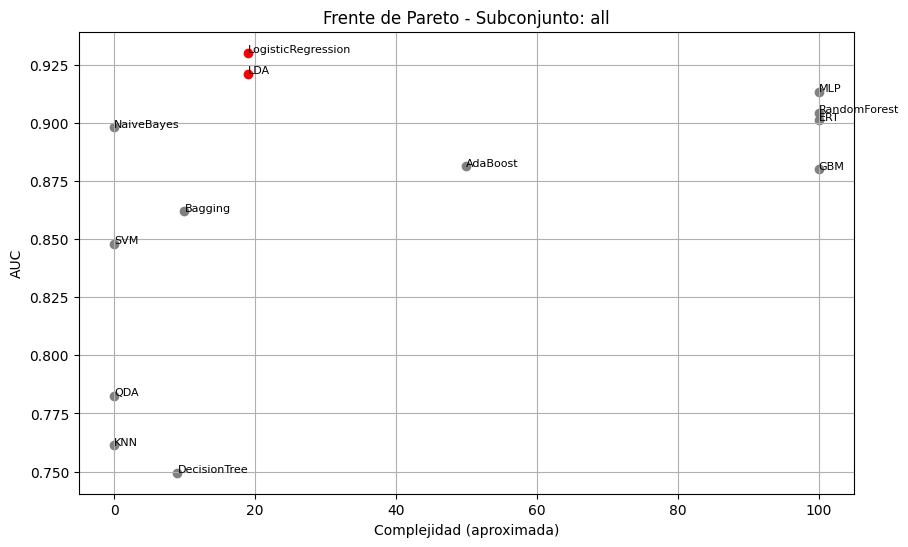

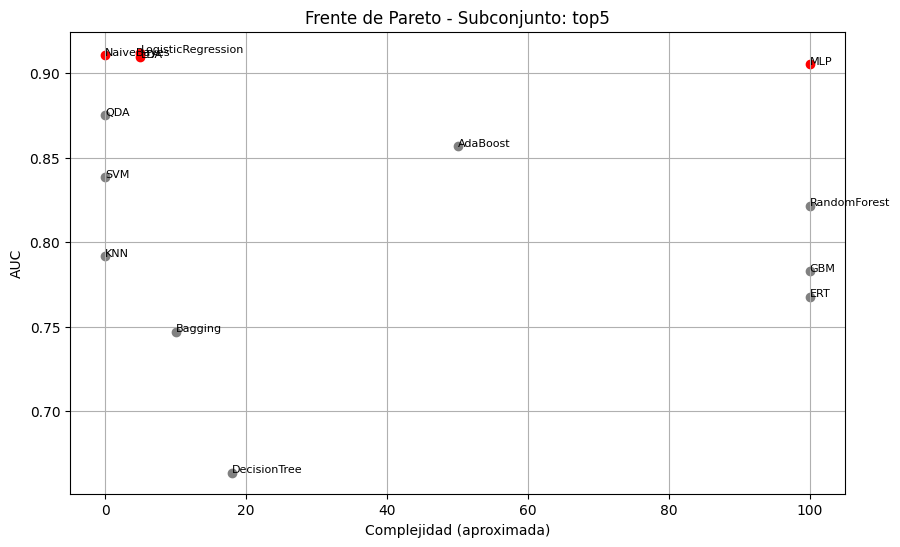

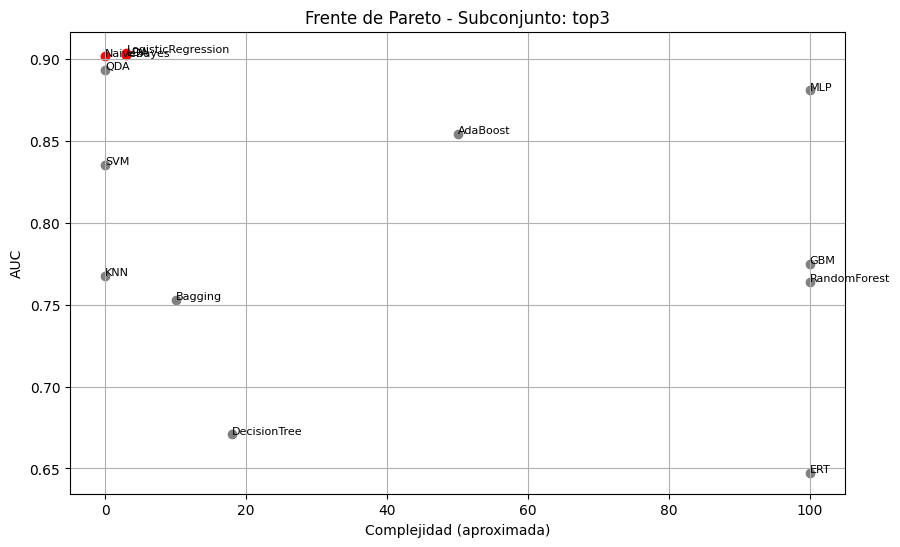

In [41]:
for subset_name in rashomon_df['Subset'].unique():
    subset_data = rashomon_df[rashomon_df['Subset'] == subset_name]

    plt.figure(figsize=(10, 6))
    for _, row in subset_data.iterrows():
        color = 'red' if row['WithinEpsilon'] else 'gray'
        plt.scatter(row['Complexity'], row['AUC'], label=row['Model'], color=color)
        plt.text(row['Complexity'], row['AUC'], row['Model'], fontsize=8)

    plt.title(f"Frente de Pareto - Subconjunto: {subset_name}")
    plt.xlabel("Complejidad (aproximada)")
    plt.ylabel("AUC")
    plt.grid(True)
    plt.show()


In [42]:
# Definir subconjuntos basados en porcentajes del ranking de atributos
total_features = ranking_df.shape[0]
top_33_count = max(1, int(total_features * 0.33))
top_66_count = max(1, int(total_features * 0.66))

feature_sets = {
    'top33': ranking_df.sort_values("Rank").head(top_33_count).index.tolist(),
    'top66': ranking_df.sort_values("Rank").head(top_66_count).index.tolist(),
    'top100': ranking_df.sort_values("Rank").index.tolist()
}

rashomon_results = []
epsilon = 0.01  # 1% del mejor AUC

for subset_name, features in feature_sets.items():
    X_sub = X[features]
    X_train_r, X_valid_r, y_train_r, y_valid_r = train_test_split(X_sub, y, test_size=0.25, random_state=42)

    subset_scores = []
    best_auc = 0

    for model_label, model in models.items():
        try:
            start = time.time()
            model.fit(X_train_r, y_train_r)
            train_time = time.time() - start

            y_pred = model.predict(X_valid_r)
            try:
                y_prob = model.predict_proba(X_valid_r)[:, 1]
            except:
                y_prob = y_pred

            auc = roc_auc_score(y_valid_r, y_prob)
            best_auc = max(best_auc, auc)

            if hasattr(model, 'n_estimators'):
                complexity = model.n_estimators
            elif hasattr(model, 'coef_'):
                complexity = model.coef_.shape[1]
            elif hasattr(model, 'hidden_layer_sizes'):
                complexity = sum(model.hidden_layer_sizes)
            elif hasattr(model, 'tree_'):
                complexity = model.tree_.max_depth
            else:
                complexity = train_time

            subset_scores.append({
                'Subset': subset_name,
                'Model': model_label,
                'AUC': auc,
                'TrainingTime': train_time,
                'Complexity': complexity
            })
        except Exception as e:
            print(f'Error with {model_label} on {subset_name}:', e)

    rashomon_models = [s for s in subset_scores if s['AUC'] >= (best_auc - epsilon)]
    rashomon_volume = len(rashomon_models)

    for score in subset_scores:
        score['BestAUC'] = best_auc
        score['RashomonVolume'] = rashomon_volume
        score['WithinEpsilon'] = score['AUC'] >= (best_auc - epsilon)

    rashomon_results.extend(subset_scores)

rashomon_df = pd.DataFrame(rashomon_results)


In [45]:
# Crear resumen por subconjunto
summary = rashomon_df.groupby('Subset').agg({
    'RashomonVolume': 'first',
    'AUC': ['mean', 'max'],
    'Complexity': 'mean'
}).reset_index()

summary.columns = ['Subset', 'RashomonVolume', 'AUC_Mean', 'AUC_Max', 'Complexity_Mean']
summary = summary.sort_values("Subset")

# Mostrar con formato
display(summary.style.format({
    "AUC_Mean": "{:.3f}",
    "AUC_Max": "{:.3f}",
    "Complexity_Mean": "{:.1f}"
}))

,Subset,RashomonVolume,AUC_Mean,AUC_Max,Complexity_Mean
0,top100,3,0.839,0.930,39.0
1,top33,4,0.837,0.912,37.4
2,top66,4,0.855,0.916,37.9


In [49]:
# Exportar resumen a CSV
summary.to_csv("rashomon_summary.csv", index=False)
print("Resumen exportado como 'rashomon_summary_HeartDisease.csv'")

Resumen exportado como 'rashomon_summary_HeartDisease.csv'


In [48]:
# Exportar todos los resultados individuales a CSV
rashomon_df.to_csv("rashomon_model_results_heartDisease.csv", index=False)
print("Resultados detallados exportados como 'rashomon_model_results_HeartDisease.csv'")


Resultados detallados exportados como 'rashomon_model_results_HeartDisease.csv'


In [51]:
# Identificar modelos en el frente de Pareto (AUC vs. Complejidad)
def is_pareto_efficient(df, perf_col="AUC", cost_col="Complexity"):
    is_efficient = []
    for i, row_i in df.iterrows():
        dominated = False
        for j, row_j in df.iterrows():
            if (
                (row_j[perf_col] >= row_i[perf_col])
                and (row_j[cost_col] <= row_i[cost_col])
                and ((row_j[perf_col] > row_i[perf_col]) or (row_j[cost_col] < row_i[cost_col]))
            ):
                dominated = True
                break
        is_efficient.append(not dominated)
    return is_efficient

# Aplicar por subconjunto
pareto_df_list = []
for subset in rashomon_df['Subset'].unique():
    df_subset = rashomon_df[rashomon_df['Subset'] == subset].copy()
    df_subset['ParetoFront'] = is_pareto_efficient(df_subset)
    pareto_df_list.append(df_subset)

pareto_df = pd.concat(pareto_df_list)

# Exportar modelos en el frente de Pareto
pareto_df[pareto_df['ParetoFront']].to_csv("rashomon_pareto_models.csv", index=False)
print("Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'")

Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'


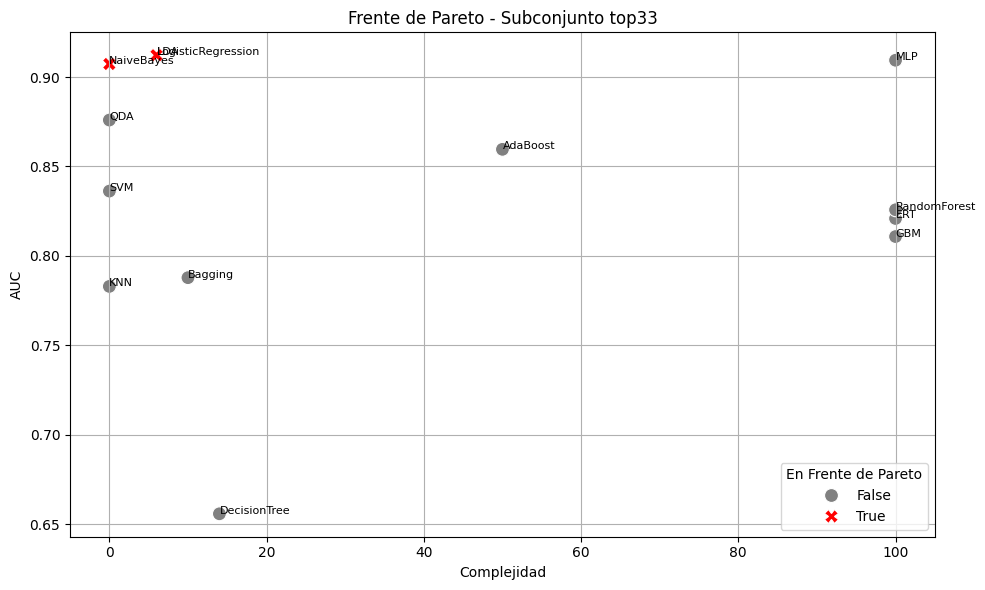

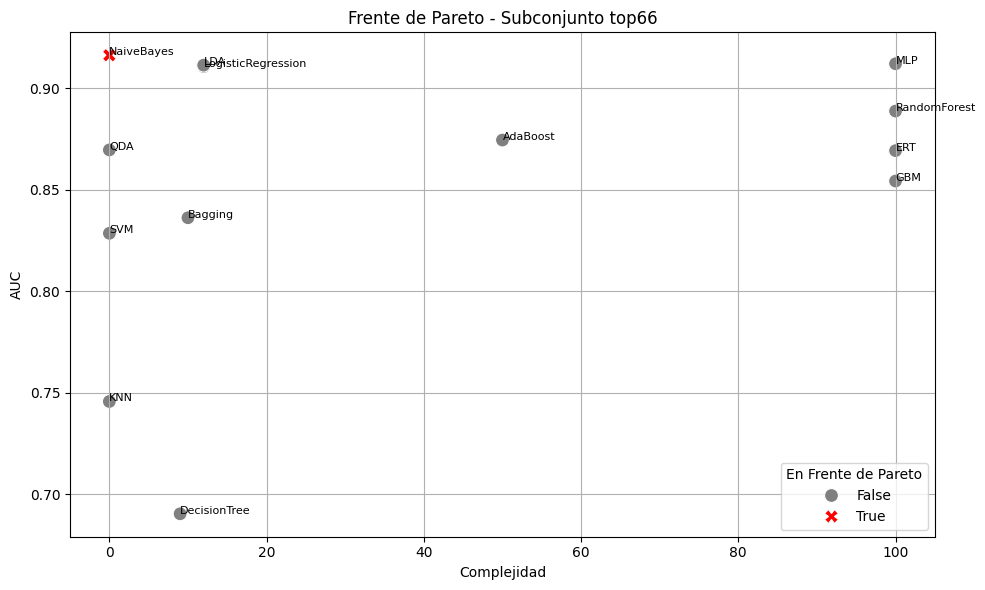

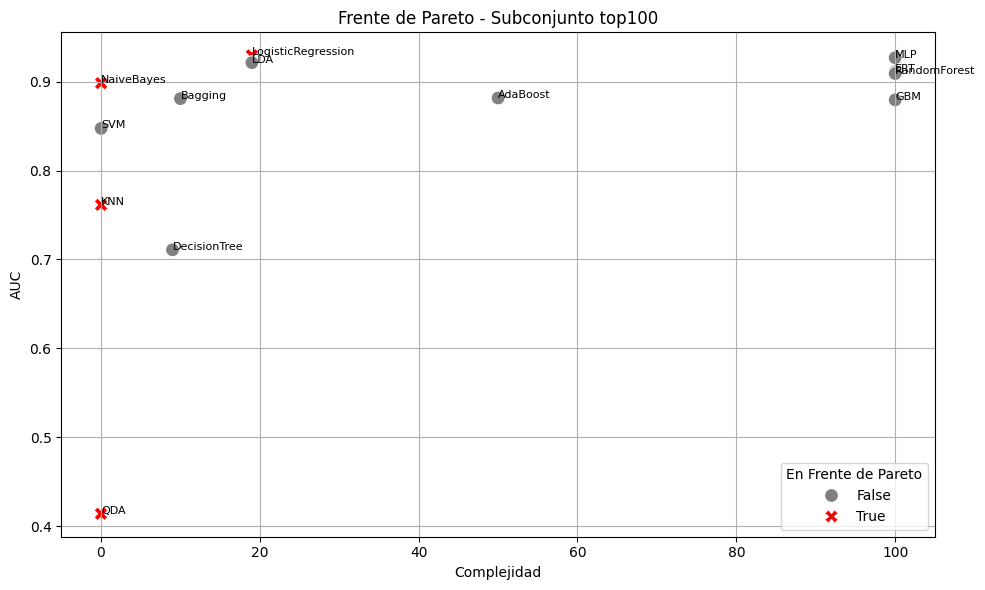

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualización del frente de Pareto para cada subconjunto
for subset in pareto_df['Subset'].unique():
    data = pareto_df[pareto_df['Subset'] == subset]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='Complexity', y='AUC',
        hue='ParetoFront',
        style='ParetoFront',
        palette={True: 'red', False: 'gray'},
        data=data,
        s=100
    )
    for _, row in data.iterrows():
        plt.text(row['Complexity'], row['AUC'], row['Model'], fontsize=8)

    plt.title(f'Frente de Pareto - Subconjunto {subset}')
    plt.xlabel('Complejidad')
    plt.ylabel('AUC')
    plt.legend(title='En Frente de Pareto')
    plt.grid(True)
    plt.tight_layout()
    plt.show()